# Analysis of experimentally measured beam loss

The beam loss at injection shall be compared to the theoretical expectation. 

Let $I_F$ be the intensity of the beam at time $T_F$ the end of INJECTION (beginning of PREPARE RAMP) and $\Delta I_i$ the intensity injected at the injection step $i$. The time of injection at the step $i$ is denoted as $T_i$. Assuming that all losses are caused by dynamic aperture, the final intensity is related to the injected intensity as 

$$ I_F = 2 \, \sum_{i=0}^N \, \Delta I_i \, \int_{D(T_F-T_i)}^{\infty} \rho(x) \, dx \, ,$$

where $\rho(x)$ is the transverse particle distribution, $D(T_F-T_i)$ is the dynamic aperture for the injected bunch at the end of INJECTION and $N$ is the number of injection steps. We are interested in relative losses, so we are going to compare the quantity

$$ r = \frac{\sum_i^N \Delta I_i - I_F}{\sum_i^N \Delta I_i} \, .$$

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytimber as pt
import time
from __future__ import print_function
import sixdesk.dist as dist
from sixdesk.da import beamloss
import sixdesk.da as da
bl = beamloss()

plt.style.use('ggplot')

# fig = plt.figure(figsize=[12,9])
font = {'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)

## Load the database and find variables if needed

In [7]:
db = pt.LoggingDB()

In [8]:
b1intensity = 'LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'
b2intensity = 'LHC.BCTDC.B6R4.B2:BEAM_INTENSITY'
lhc_energy  = 'LHC.BQSH.B1:ENERGY'
beam_mode   = 'LHC.CISG.CCR.A:BEAM_MODE'
chroma      = 'LHC.BOFSU:CHROMA_B1_H'
emit1x      = 'LHC.BQSH.B1:NORM_EMITTANCE_BSRT'
emit2x      = 'LHC.BQSH.B2:NORM_EMITTANCE_BSRT'
emit1v      = 'LHC.BQSV.B1:NORM_EMITTANCE_BSRT'
emit2v      = 'LHC.BQSV.B2:NORM_EMITTANCE_BSRT'

In [9]:
def get_injection_phases(fill_number):
    '''Get the time stamps of the beginning and end of the injection phase for a given fill.'''
    data = db.getLHCFillData(fill_number)['beamModes']
    for j in data:
        if j['mode']=='INJPHYS':
            return j['startTime'], j['endTime']

In [10]:
def _get_raw_injection_times(dataset,thresh=0.005e14):    
    time_array, intensity_array = dataset
    indices = np.diff(intensity_array)>thresh
    indices = np.append(indices, False)
    return time_array[indices], intensity_array[indices]

def get_injection_times(dataset, thresh=0.005e14):
    injection_times, injection_intensity = _get_raw_injection_times(dataset,thresh=thresh)
    
    steps_indices   = np.diff(injection_times)>2.      # use only steps which are more than 2 seconds apart from another
    steps_indices   = np.append(steps_indices, True)
    
    injection_intensity = injection_intensity[steps_indices]
    injection_times     = injection_times[steps_indices]
    return injection_times, injection_intensity


def get_delta_i(dataset):
    time_steps, intensity_steps    = get_injection_times(dataset)
    time_injection, data_injection = dataset
    output = []
    for n in range(len(time_steps)):
        int_before_step = data_injection[time_injection <= time_steps[n]+5]
        output.append([time_steps[n], intensity_steps[n], int_before_step[-1] - int_before_step[-10]])
    return pd.DataFrame(output,columns=['time','intensity_before_injection','injected_intensity'])

def get_experimental_beam_loss(dataset):
    injected_beam = get_delta_i(dataset)
    times_to_eoi  = get_time_to_prepare_ramp(dataset)
    
    return (injected_beam['injected_intensity'].sum()-dataset[1][-1])/injected_beam['injected_intensity'].sum()

def get_time_to_prepare_ramp(dataset):
    return dataset[0][-1] - get_delta_i(dataset)['time']

def get_simulated_loss(data, fit_params, realizations):
    
    injected_beam = get_delta_i(data)
    times_to_eoi  = get_time_to_prepare_ramp(data)    
    
    total_intensity = (1 - bl.loss_from_fit_params(fit_params, 
                                                   time=times_to_eoi[0], 
                                                   realizations=realizations))*injected_beam['injected_intensity'][0]
    
    for j in range(1,len(times_to_eoi)):
        total_intensity = total_intensity + (1 - bl.loss_from_fit_params(fit_params, 
                                                                         time=times_to_eoi[j], 
                                                                         realizations=realizations))*injected_beam['injected_intensity'][j]
    return (sum(injected_beam['injected_intensity'])-total_intensity)/sum(injected_beam['injected_intensity'])

def get_loss_from_da(a, seconds):
    a.get_extrapolated_da(seconds=seconds,realizations=10)
    daseries = a.extrapolated_da['exda_{0}_sec'.format(seconds)]
    return bl.get_loss_from_da_series(daseries)

## Analyze the past runs 
### Beam 1

Load the data for 2016 and calculate the observed beam loss between the first injection and the beginning of PREPARE RAMP. First initialize the dynamic aperture simulations and get the fit parameters for three different chromaticities.

In [11]:
emittance = 2.0

dbname = '/media/phermes/local/DA_studies/injection_2016/db/lhc_b1_inj_2016_qp_{0}_ioct_{1}.db'
a1 = da.davst(dbname.format(20,40), emittance)
b1 = da.davst(dbname.format(18,40), emittance)
c1 = da.davst(dbname.format(16,40), emittance)

a1.fit_params = a1.fit_params.append(b1.fit_params)
a1.fit_params = a1.fit_params.append(c1.fit_params)
a1.fit_params = a1.fit_params.reset_index(drop=True)

dbname = '/media/phermes/local/DA_studies/injection_2016/db/lhc_b2_inj_2016_qp_{0}_ioct_{1}.db'
a2 = da.davst(dbname.format(20,40), emittance)
b2 = da.davst(dbname.format(18,40), emittance)
c2 = da.davst(dbname.format(16,40), emittance)

a2.fit_params = a2.fit_params.append(b2.fit_params)
a2.fit_params = a2.fit_params.append(c2.fit_params)
a2.fit_params = a2.fit_params.reset_index(drop=True)

## Try with unequal emittances

### Mean emittances immediately after injection (start)

In [19]:
# mean emittances immediately after injection
emittance = None
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_20_ioct_40_emit_1.80_1.55.db'
a1s = da.davst(dbname.format(20,40), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_18_ioct_40_emit_1.80_1.55.db'
b1s = da.davst(dbname.format(18,40), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_16_ioct_40_emit_1.80_1.55.db'
c1s = da.davst(dbname.format(16,40), emittance)

# for database in [a1,b1,c1]:
#     database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1s.fit_params = a1s.fit_params.append(b1s.fit_params)
a1s.fit_params = a1s.fit_params.append(c1s.fit_params)
a1s.fit_params = a1s.fit_params.reset_index(drop=True)    

a1s.get_extrapolated_da(minutes=30,realizations=1)

### Mean emittances at the end of injection (end)

In [20]:
emittance = None
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_20_ioct_40_emit_2.00_1.66.db'
a1e = da.davst(dbname.format(20,40), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_18_ioct_40_emit_2.00_1.66.db'
b1e = da.davst(dbname.format(18,40), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_16_ioct_40_emit_2.00_1.66.db'
c1e = da.davst(dbname.format(16,40), emittance)

# for database in [a1,b1,c1]:
#     database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1e.fit_params = a1e.fit_params.append(b1e.fit_params)
a1e.fit_params = a1e.fit_params.append(c1e.fit_params)
a1e.fit_params = a1e.fit_params.reset_index(drop=True)    

a1e.get_extrapolated_da(minutes=30, realizations=1)

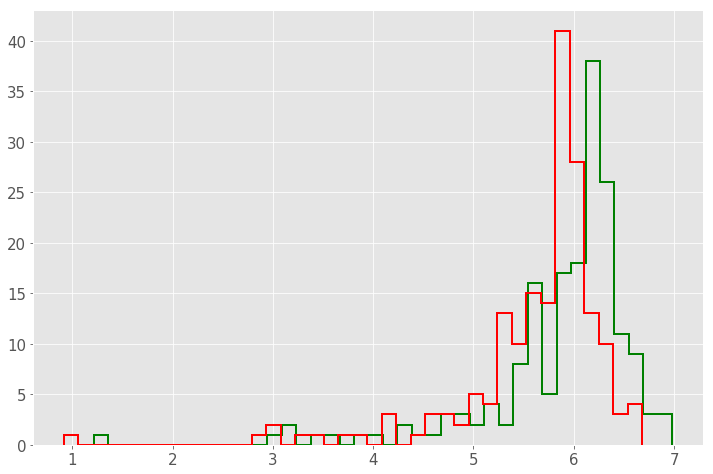

In [21]:
fig = plt.figure(figsize=(12,8))
plt.hist(a1s.extrapolated_da['exda_1800_sec'],bins=40, color='green',histtype='step',lw=2)
plt.hist(a1e.extrapolated_da['exda_1800_sec'],bins=40, color='red',histtype='step',lw=2)
plt.show()

## Use a set of measured emittances (beginning of ramp)

In [69]:
horizontal_emittances = np.array([ 2.05580332,  2.11088284,  2.06265796,  1.86904067,  1.97085083,
        2.1403692 ,  1.7498488 ,  2.16651645,  2.05066803,  1.76762471,
        2.15778717,  1.97253662,  1.97590983,  2.21565037,  1.73213837,
        1.87731001,  1.8197087 ,  1.91218897,  2.0455376 ,  1.89721162,
        1.95066352,  2.02166   ,  1.94059908,  1.95066352,  1.95234282,
        1.7160948 ,  1.94395173,  1.88227811,  2.09188676,  1.82953614,
        1.95066352,  1.74018045,  1.66511897,  2.05751617,  1.69691393,
        2.10915322,  2.06608853,  1.98773311,  2.23153351,  1.8905691 ,
        1.9809737 ,  2.07123843,  2.13515437,  2.1525561 ,  1.95570304,
        1.77734825,  1.7498488 ,  2.1473299 ,  2.25987843,  2.15081349])

vertical_emittances = np.array([ 1.7609516 ,  1.58455192,  1.92766955,  1.78582726,  1.64867554,
        1.69387161,  1.35900241,  1.6971991 ,  1.7643349 ,  1.67396525,
        1.58347438,  1.75869762,  1.56842138,  1.95353423,  1.59210338,
        1.65086814,  1.65415936,  1.74744631,  1.76885031,  1.47833263,
        1.69054691,  1.56949458,  1.78469329,  1.57916732,  1.68169468,
        1.46370934,  1.50670629,  1.554498  ,  1.57271604,  1.58994427,
        1.85212782,  1.55129235,  1.68611831,  1.72503671,  1.43774746,
        1.84522077,  1.66845354,  1.79945904,  1.70386245,  1.61484891,
        1.60833624,  1.67175964,  1.63008856,  1.71722264,  1.71276429,
        1.53956219,  1.55342914,  1.70608605,  1.89846002,  1.7049741 ])

emittance = None
fit_params = pd.DataFrame(columns=[u'seed', u'angle', u'emit', u'd', u'b', u'k', u'chi', u'derr', u'berr'])

for j in range(1,len(horizontal_emittances)):
    dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
    a1e = da.davst(dbname.format(horizontal_emittances[j],vertical_emittances[j]), emittance)
    dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
    b1e = da.davst(dbname.format(horizontal_emittances[j],vertical_emittances[j]), emittance)
    dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
    c1e = da.davst(dbname.format(horizontal_emittances[j],vertical_emittances[j]), emittance)
    
#     a1e.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
#     b1e.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
#     c1e.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
    fit_params = fit_params.append(a1e.fit_params)
    fit_params = fit_params.append(b1e.fit_params)
    fit_params = fit_params.append(c1e.fit_params)


    

# a1e.fit_params = a1e.fit_params.reset_index(drop=True)    

# a1e.get_extrapolated_da(minutes=30)

a1e.fit_params = fit_params

try:
    a1e.get_extrapolated_da(minutes=30)
except ValueError:
    pass

# Get the time between injection and start ramp

In [12]:
fills  = pd.read_csv('fills_2016.csv',usecols=[0],names=['fill'],skiprows=1) # all fills in 2016 in stable beams
fills  = np.array(fills['fill'])

In [72]:
simloss1, outputb1 = np.array([]), []
lengths=[]
# fills = [5423]
times = np.array([])
for i, fill in enumerate(fills):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b1intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b1intensity])
        inj    = get_injection_times(data[b1intensity])
        newinj = inj[0]-start
        length          = end-start
        print('{0}/{1} Fill number: {2}'.format(i+1,len(fills),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            times = np.append(times, newinj)

    except IndexError:
        pass
# outputb1 = pd.DataFrame(outputb1,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


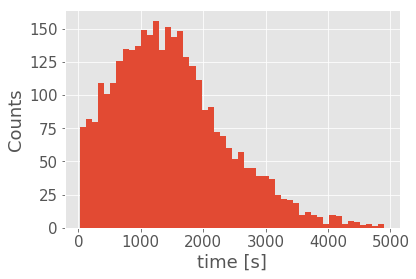

In [74]:
plt.hist(times,bins=50)
plt.xlabel("time [s]")
plt.ylabel("Counts")
plt.show()

In [75]:
pd.Series(times).describe()

count    3343.000000
mean     1493.421951
std       895.062373
min        25.207000
25%       819.244500
50%      1387.905000
75%      2013.027000
max      4902.558000
dtype: float64

In [388]:
df = pd.read_csv('/home/phermes/Desktop/exportedCSV-1.csv')
fills = df['Fill Number']

In [76]:
simloss1, outputb1 = np.array([]), []
lengths=[]
# fills = [5423]
times = np.array([])
for i, fill in enumerate(fills1):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b1intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b1intensity])
        inj    = get_injection_times(data[b1intensity])
        newinj = inj[0]-start
        length          = end-start
        print('{0}/{1} Fill number: {2}'.format(i+1,len(fills),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            times = np.append(times, newinj)

    except IndexError:
        pass
# outputb1 = pd.DataFrame(outputb1,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


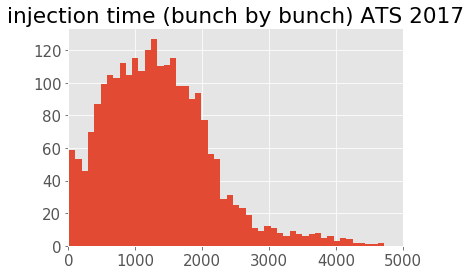

In [77]:
plt.hist(times,bins=50)
plt.xlim(0,5000)
plt.title('injection time (bunch by bunch) ATS 2017')
plt.show()

In [78]:
pd.Series(times).describe()

count    2462.000000
mean     1345.915482
std       794.143915
min        11.165000
25%       757.442500
50%      1267.343000
75%      1807.103750
max      4715.829000
dtype: float64

In [79]:
simloss1, outputb1 = np.array([]), []
lengths=[]
# fills = [5423]
times = np.array([])
for i, fill in enumerate(fills2):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b1intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b1intensity])
        inj    = get_injection_times(data[b1intensity])
        newinj = inj[0]-start
        length          = end-start
        print('{0}/{1} Fill number: {2}'.format(i+1,len(fills),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            times = np.append(times, newinj)

    except IndexError:
        pass
# outputb1 = pd.DataFrame(outputb1,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


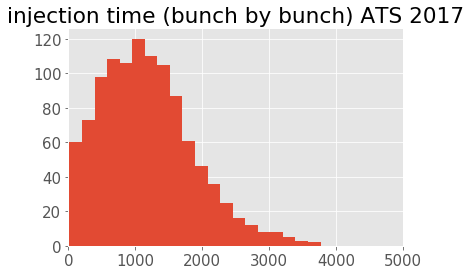

In [80]:
plt.hist(times,bins=50)
plt.xlim(0,5000)
plt.title('injection time (bunch by bunch) ATS 2017')
plt.show()

In [82]:
pd.Series(times).describe()

count    1106.000000
mean     1297.542580
std      1155.343771
min        16.822000
25%       661.640000
50%      1124.795000
75%      1616.419750
max      9391.412000
dtype: float64

## Read losses for B1

In [13]:
import sqlite3

In [14]:
fills  = pd.read_csv('fills_2016.csv',usecols=[0],names=['fill'],skiprows=1) # all fills in 2016 in stable beams
fills  = np.array(fills['fill'])

### Read the DA simulations with different emittances

In [18]:
# mean emittances immediately after injection
emittance = None
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_20_ioct_40_emit_1.80_1.55.db'
a1s = da.davst(dbname.format(20,40), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_18_ioct_40_emit_1.80_1.55.db'
b1s = da.davst(dbname.format(18,40), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_16_ioct_40_emit_1.80_1.55.db'
c1s = da.davst(dbname.format(16,40), emittance)

# for database in [a1,b1,c1]:
#     database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1s.fit_params = a1s.fit_params.append(b1s.fit_params)
a1s.fit_params = a1s.fit_params.append(c1s.fit_params)
a1s.fit_params = a1s.fit_params.reset_index(drop=True)    

a1s.get_extrapolated_da(minutes=30,realizations=1)

# mean emittances at start of ramp

emittance = None
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_20_ioct_40_emit_2.00_1.66.db'
a1e = da.davst(dbname.format(20,40), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_18_ioct_40_emit_2.00_1.66.db'
b1e = da.davst(dbname.format(18,40), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_16_ioct_40_emit_2.00_1.66.db'
c1e = da.davst(dbname.format(16,40), emittance)

# for database in [a1,b1,c1]:
#     database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1e.fit_params = a1e.fit_params.append(b1e.fit_params)
a1e.fit_params = a1e.fit_params.append(c1e.fit_params)
a1e.fit_params = a1e.fit_params.reset_index(drop=True)    

a1e.get_extrapolated_da(minutes=30, realizations=1)

In [ ]:
simloss1_start, outputb1 = np.array([]), []
simloss1_end = np.array([])
for i, fill in enumerate(fills[2:]):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b1intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b1intensity])
        length          = end - start
        print('{0}/{1} Fill number: {2}'.format(i,len(fills[2:]),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            outputb1.append([fill,experimental,length])
            
            loss = get_loss_from_da(a1s, int(length))
            simloss1_start = np.append(simloss1_start, loss)
            
            loss = get_loss_from_da(a1e, int(length))
            simloss1_end = np.append(simloss1_end, loss)            
    except IndexError:
        pass
    
outputb1 = pd.DataFrame(outputb1,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


In [ ]:
fig = plt.figure(figsize=[12,7])
plt.hist(simloss1_start,bins=1000,normed=True,histtype='step',label=r'simulated ($\epsilon_x/\epsilon_y = 1.8 / 1.6 \, \mu$m)',color='blue',lw=2)
plt.hist(simloss1_end,bins=1000,normed=True,histtype='step',label=r'simulated ($\epsilon_x/\epsilon_y = 2.0 / 1.7 \, \mu$m)',color='green',lw=2)

plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016)')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

In [432]:
pd.Series(simloss1).describe()

count    3.834962e+08
mean     1.162071e-02
std      3.321184e-02
min      1.127210e-13
25%      5.950910e-03
50%      8.905690e-03
75%      1.189430e-02
max      9.307740e-01
dtype: float64

## Use different emittances

Here, we use a subset of emittances randomly sampled from the measured data

In [22]:
simloss1_start, outputb1 = np.array([]), []
simloss1_end = np.array([])
for i, fill in enumerate(fills):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b1intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b1intensity])
        length          = end - start
        print('{0}/{1} Fill number: {2}'.format(i+1,len(fills),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            outputb1.append([fill,experimental,length])           
    except IndexError:
        pass
    
outputb1 = pd.DataFrame(outputb1,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


In [23]:
from sixdesk.dist import dgauss

def get_loss_for_dist(d,time, a1e=a1e):
    try:
        a1e.get_extrapolated_da(seconds=time)
    except ValueError:
        pass
    loss = []
    for daval in a1e.extrapolated_da['exda_{0}_sec'.format(time)]:
        loss.append(d.losses_above_nsig1(daval))
    return loss

In [24]:
d = dgauss(0.877, 1.0, 3.7)
simlss1 = get_loss_for_dist(d, 1800)
d.losses_above_nsig1(9)

0.0018447281052147446

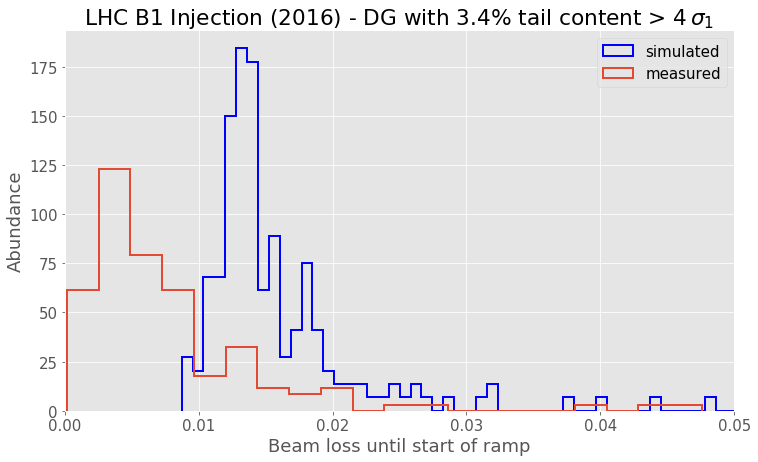

In [26]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss1,bins=500,normed=True,histtype='step',label=r'simulated',color='blue',lw=2)
# plt.hist(simloss1_end,bins=1000,normed=True,histtype='step',label=r'simulated ($\epsilon_x/\epsilon_y = 2.0 / 1.7 \, \mu$m)',color='green',lw=2)

plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) - DG with 3.4% tail content > $4\,\sigma_1$' )
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

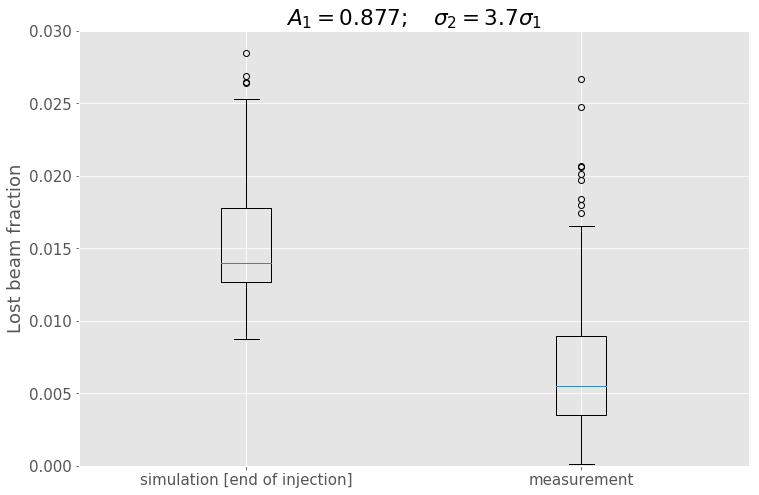

In [31]:
fig = plt.figure(figsize=[12,8])
plt.boxplot([simlss1, outputb1['experimental']], labels=['simulation [end of injection]','measurement'])
plt.ylabel("Lost beam fraction")
plt.ylim(0,0.03)
plt.title(r'$ A_1 = 0.877 ;\quad \sigma_2 = 3.7 \sigma_1$')
plt.show()

In [18]:
d = dgauss(0.821, 1.0, 2.5)
simlss1 = get_loss_for_dist(d,1800)
simlss1 = np.array(simlss1)
print(d.losses_above_nsig1(4))

0.0196701506075


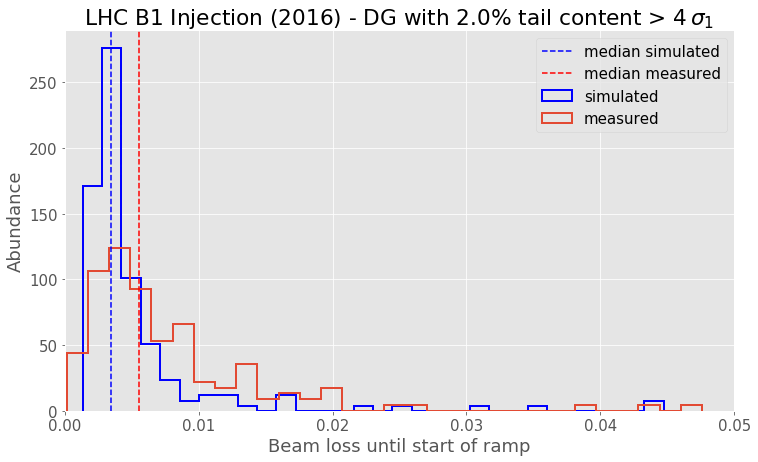

In [20]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss1[simlss1<0.05],bins=30,normed=True,histtype='step',label=r'simulated',color='blue',lw=2)

plt.axvline(np.median(simlss1), 0,1000, color='blue', ls='dashed', label='median simulated')
plt.axvline(np.median(outputb1['experimental']), 0,1000, color='red', ls='dashed', label='median measured')

plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=30, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) - DG with 2.0% tail content > $4\,\sigma_1$' )
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

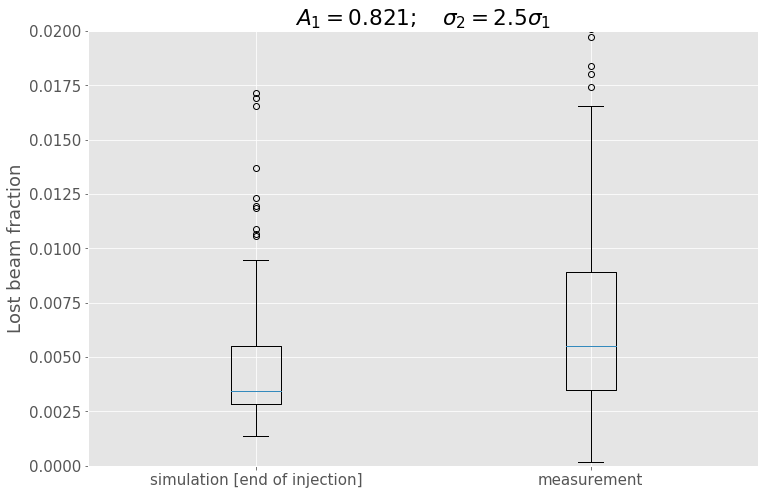

In [26]:
fig = plt.figure(figsize=[12,8])
plt.boxplot([simlss1, outputb1['experimental']], labels=['simulation [end of injection]','measurement'])
plt.ylabel("Lost beam fraction")
plt.ylim(0,0.02)
plt.title(r'$ A_1 = 0.821 ;\quad \sigma_2 = 2.5 \sigma_1$')
plt.show()

### Use different DGaussians

In [15]:
distributions = pd.read_csv('/afs/cern.ch/work/p/phermes/public/loss_vs_da/functions/distributions.csv', 
                            delim_whitespace=True,usecols=[0,1,2], names=['a1','sig2','tail'])

### samples with different tail contents

In [27]:
selected_dists = distributions[distributions['sig2']<3.0]
simlss_many = []
for _ in range(10):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800))
simlss_many = [item for sublist in simlss_many for item in sublist]    

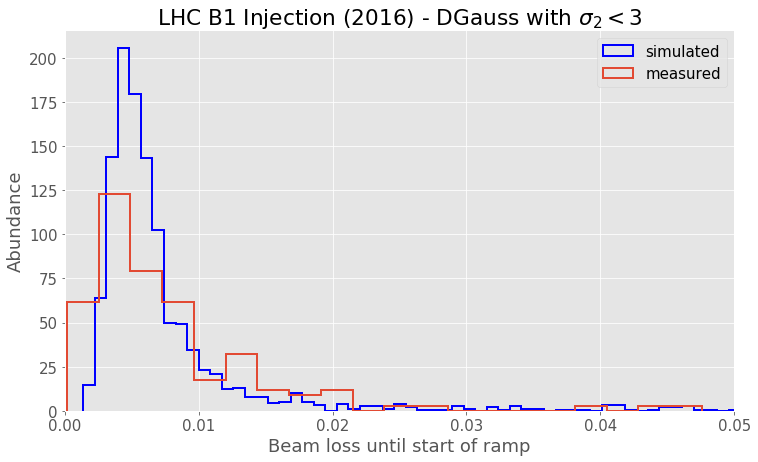

In [28]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=500,normed=True,histtype='step',label=r'simulated',color='blue',lw=2)
plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) - DGauss with $\sigma_2<3$')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

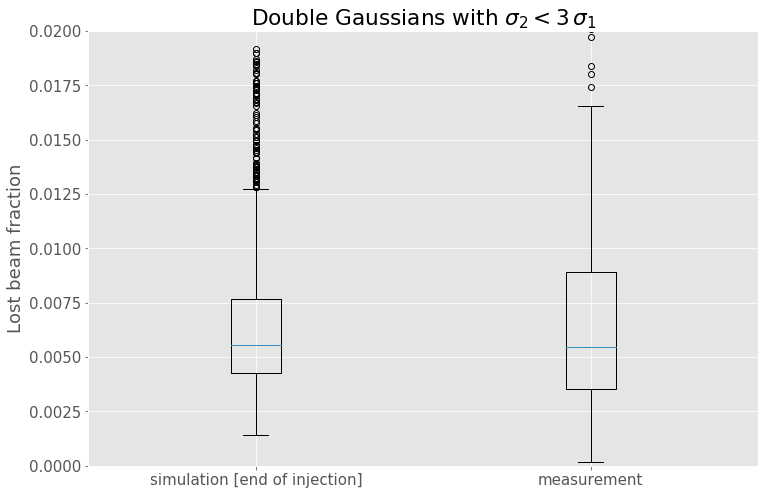

In [29]:
fig = plt.figure(figsize=[12,8])
plt.boxplot([simlss_many, outputb1['experimental']], labels=['simulation [end of injection]','measurement'])
plt.ylabel("Lost beam fraction")
plt.ylim(0,0.02)
plt.title(r'Double Gaussians with $\sigma_2 < 3 \, \sigma_1$')
plt.show()

In [47]:
selected_dists = distributions[distributions['sig2']>3.0]
simlss_many = []
for _ in range(10):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800))
simlss_many = [item for sublist in simlss_many for item in sublist]

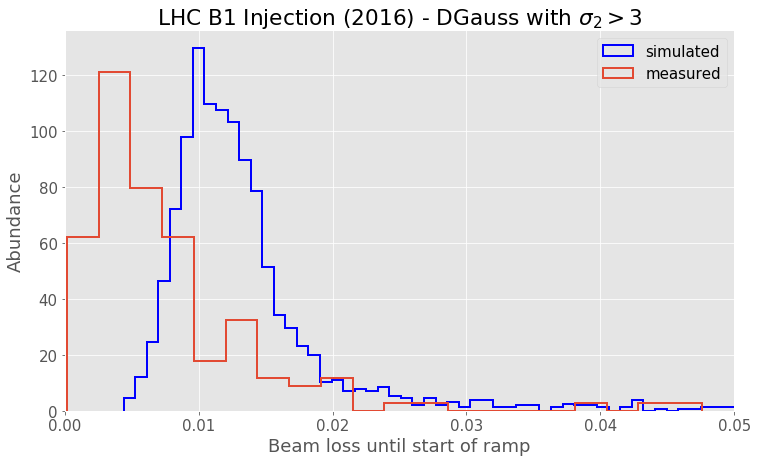

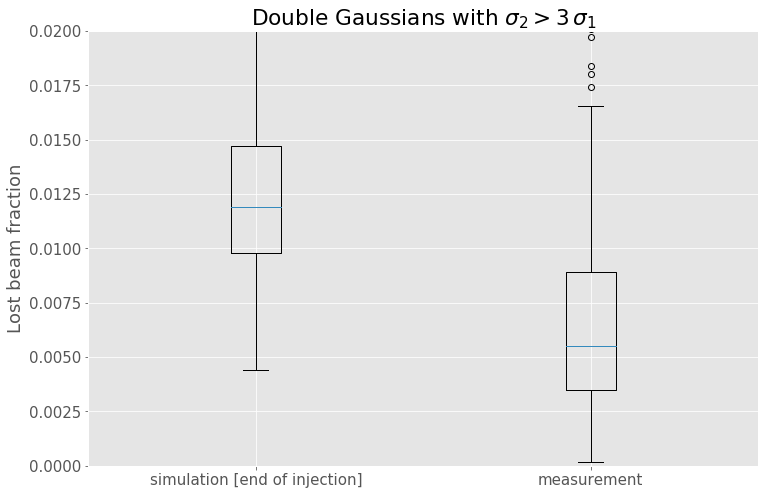

In [48]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=500,normed=True,histtype='step',label=r'simulated',color='blue',lw=2)
plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) - DGauss with $\sigma_2>3$')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

fig = plt.figure(figsize=[12,8])
plt.boxplot([simlss_many, outputb1['experimental']], labels=['simulation [end of injection]','measurement'])
plt.ylabel("Lost beam fraction")
plt.ylim(0,0.02)
plt.title(r'Double Gaussians with $\sigma_2 > 3 \, \sigma_1$')
plt.show()

Hence, in spite of the fact that the two subsets of double gaussians have the same tail content (and are compatible with the experimental findings of 2009), they have different predictive powers. 

## Using the subset of double Gaussians with nominal emittances

In [66]:
selected_dists = distributions[distributions['sig2']<3.0]
simlss_many = []
for _ in range(10):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800,a1e=a1))
simlss_many = [item for sublist in simlss_many for item in sublist]    

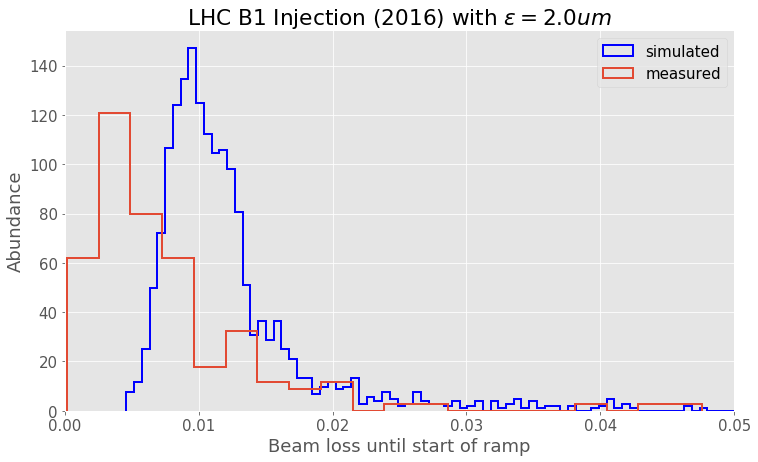

In [67]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=500,normed=True,histtype='step',label=r'simulated',color='blue',lw=2)
plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) with $\epsilon=2.0um$')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

## Selected distributions with the mean of measured emittances

In [30]:
selected_dists = distributions[distributions['sig2']<3.0]
simlss_many = []
for _ in range(10):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800,a1e=a1e))
simlss_many = [item for sublist in simlss_many for item in sublist]  

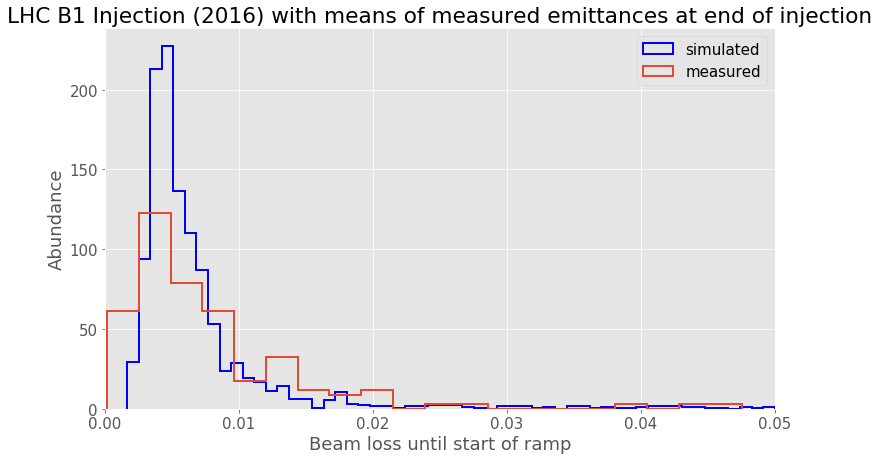

In [31]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=500,normed=True,histtype='step',label=r'simulated',color='blue',lw=2)
plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) with means of measured emittances at end of injection')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

In [32]:
selected_dists = distributions[distributions['sig2']<3.0]
simlss_many = []
for _ in range(10):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800,a1e=a1s))
simlss_many = [item for sublist in simlss_many for item in sublist]  

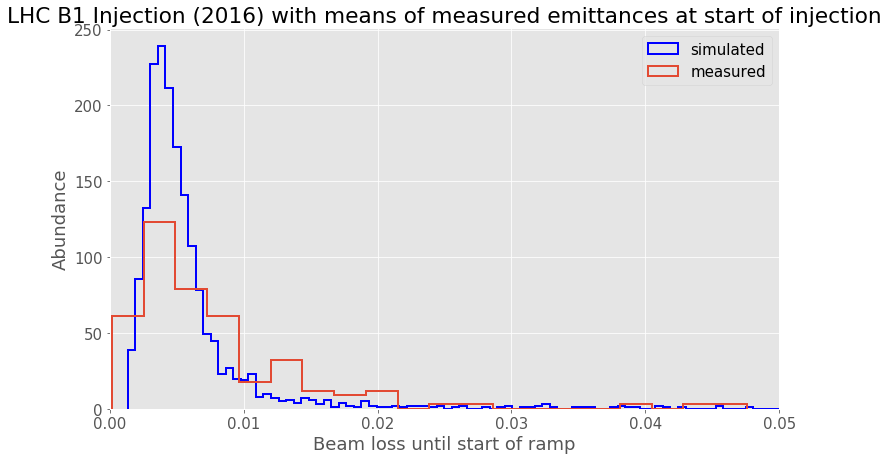

In [33]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=500,normed=True,histtype='step',label=r'simulated',color='blue',lw=2)
plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) with means of measured emittances at start of injection')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

## Using mean measured emittance and new DGauss estimates by Hector

In [34]:
newdist = pd.read_csv("hector_distributions.csv", delim_whitespace=True, names=['i1','i2','mu1','mu2','sig1','sig2'])

In [35]:
newdist

i1     i2       mu1       mu2   sig1  sig2
0   0.190  0.856  0.002940 -0.000610  0.853  1.33
1   0.228  0.806 -0.000740  0.000220  0.857  1.39
2   0.470  0.558  0.000746 -0.000864  1.000  1.59
3   0.513  0.514  0.000103 -0.000188  1.020  1.64
4   0.545  0.479  0.000200 -0.000286  1.040  1.68
5   0.562  0.462  0.000049 -0.000036  1.060  1.71
6   0.602  0.426  0.000002  0.000015  1.130  1.78
7   0.641  0.388 -0.000025  0.000182  1.180  1.85
8   0.692  0.336  0.000044 -0.000132  1.220  1.91
9   0.194  0.844 -0.000405  0.000061  1.110  1.12
10  0.234  0.793 -0.000017 -0.000008  1.110  1.11
11  0.853  0.171 -0.000002 -0.000172  1.060  1.84
12  0.861  0.163  0.000277 -0.002910  1.070  1.87
13  0.854  0.168 -0.000029 -0.000140  1.070  1.94
14  0.864  0.157 -0.000692  0.007230  1.080  1.99
15  0.878  0.153 -0.000050  0.000858  1.140  2.10
16  0.834  0.204  0.000151 -0.000720  1.200  2.04
17  0.892  0.146  0.000496 -0.005600  1.250  2.22

In [46]:
selected_dists = distributions[distributions['sig2']<3.0]
simlss_many = []
for j in range(len(newdist)):
    distr = newdist.iloc[j]
    d = dgauss(distr['i1'], distr['sig1'], distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800,a1e=a1e))
simlss_many = [item for sublist in simlss_many for item in sublist]  

In [47]:
pd.Series(simlss_many).describe()

count    3.240000e+03
mean     3.266248e-03
std      3.206687e-02
min      2.383475e-11
25%      5.965864e-05
50%      1.188002e-04
75%      2.730981e-04
max      5.249140e-01
dtype: float64

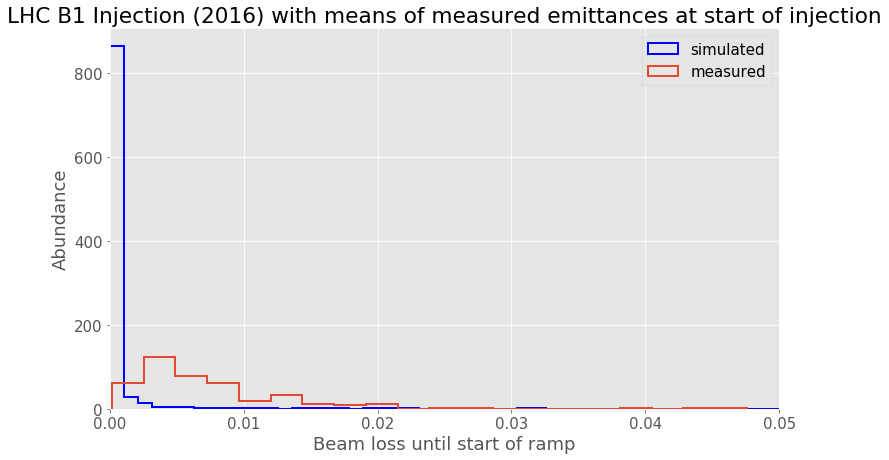

In [50]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=500,normed=True,histtype='step',label=r'simulated',color='blue',lw=2)
plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) with means of measured emittances at start of injection')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

In [39]:
d.losses_above_nsig(4)

0.0013471603378756264

In [51]:
simlss_many = []
for j in range(len(newdist)):
    distr = newdist.iloc[j]
    d = dgauss(distr['i1'], distr['sig1'], distr['sig2'])
    simlss_many.append(d.losses_above_nsig1(4))

In [52]:
pd.Series(simlss_many).describe()

count    18.000000
mean      0.004401
std       0.002578
min       0.000063
25%       0.003151
50%       0.003972
75%       0.006007
max       0.010557
dtype: float64

## Identify distributions compatible to measured data

Clearly, we wish to have distributions with tail contents dropping off quickly with increasing amplitudes. From the measured data we know that the tail content between 7.73 and 7.75 sigma should be smaller than 1e-5 (see Florians thesis). Hence, we can impose this constraint to identify physical distributions from the subset of distributions defined by the tail content above 4$\,\sigma_1$.

In [12]:
int9 = []
for ff in distributions.iterrows():
    d = dgauss(ff[1]['a1'], 1.0, ff[1]['sig2'])
    int9.append(d.losses_above_nsig1(7.73)-d.losses_above_nsig1(7.75))

In [13]:
int9 = pd.Series(int9)/2
int9.describe()

count    1492.000000
mean        0.000020
std         0.000007
min         0.000004
25%         0.000014
50%         0.000021
75%         0.000025
max         0.000033
dtype: float64

In [62]:
selected_dists = distributions[int9<1e-5]
simlss_many = []
for _ in range(20):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800,a1e=a1s))
simlss_many = [item for sublist in simlss_many for item in sublist]  

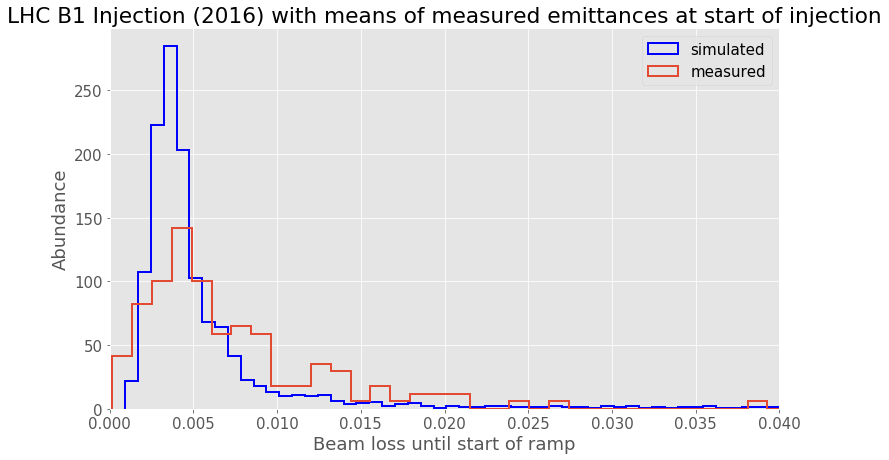

In [63]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=400,normed=True,histtype='step',label=r'simulated',color='blue',lw=2)
plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=40, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) with means of measured emittances at start of injection')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.04)
plt.show()

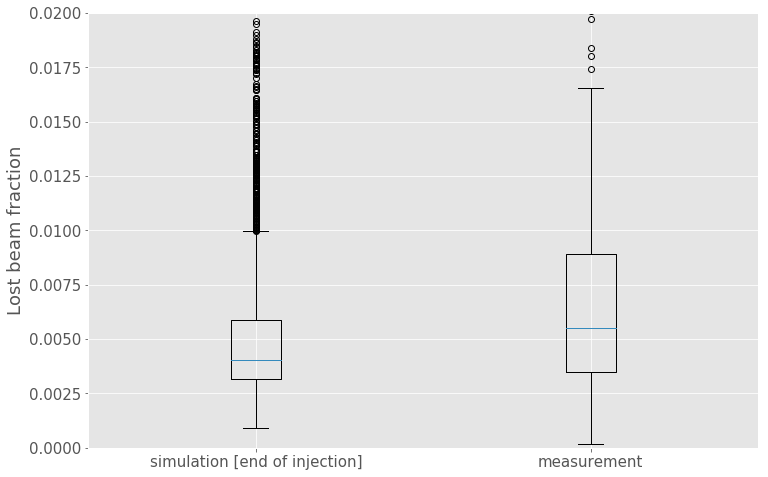

In [64]:
fig = plt.figure(figsize=[12,8])
plt.boxplot([simlss_many,outputb1['experimental']], labels=['simulation [end of injection]','measurement'])
plt.ylabel("Lost beam fraction")
plt.ylim(0,0.02)
plt.show()

In [65]:
selected_dists['sig2'].describe()

count    196.000000
mean       2.680612
std        0.119964
min        2.400000
25%        2.600000
50%        2.700000
75%        2.800000
max        3.000000
Name: sig2, dtype: float64

## Use the selected set of distributions with random samples of different emittances

In [22]:
horizontal_emittances = np.array([ 2.05580332,  2.11088284,  2.06265796,  1.86904067,  1.97085083,
        2.1403692 ,  1.7498488 ,  2.16651645,  2.05066803,  1.76762471,
        2.15778717,  1.97253662,  1.97590983,  2.21565037,  1.73213837,
        1.87731001,  1.8197087 ,  1.91218897,  2.0455376 ,  1.89721162,
        1.95066352,  2.02166   ,  1.94059908,  1.95066352,  1.95234282,
        1.7160948 ,  1.94395173,  1.88227811,  2.09188676,  1.82953614,
        1.95066352,  1.74018045,  1.66511897,  2.05751617,  1.69691393,
        2.10915322,  2.06608853,  1.98773311,  2.23153351,  1.8905691 ,
        1.9809737 ,  2.07123843,  2.13515437,  2.1525561 ,  1.95570304,
        1.77734825,  1.7498488 ,  2.1473299 ,  2.25987843,  2.15081349])

vertical_emittances = np.array([ 1.7609516 ,  1.58455192,  1.92766955,  1.78582726,  1.64867554,
        1.69387161,  1.35900241,  1.6971991 ,  1.7643349 ,  1.67396525,
        1.58347438,  1.75869762,  1.56842138,  1.95353423,  1.59210338,
        1.65086814,  1.65415936,  1.74744631,  1.76885031,  1.47833263,
        1.69054691,  1.56949458,  1.78469329,  1.57916732,  1.68169468,
        1.46370934,  1.50670629,  1.554498  ,  1.57271604,  1.58994427,
        1.85212782,  1.55129235,  1.68611831,  1.72503671,  1.43774746,
        1.84522077,  1.66845354,  1.79945904,  1.70386245,  1.61484891,
        1.60833624,  1.67175964,  1.63008856,  1.71722264,  1.71276429,
        1.53956219,  1.55342914,  1.70608605,  1.89846002,  1.7049741 ])

emittance = None
fit_params = pd.DataFrame(columns=[u'seed', u'angle', u'emit', u'd', u'b', u'k', u'chi', u'derr', u'berr'])

for j in range(1,len(horizontal_emittances)):
    dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
    a1e = da.davst(dbname.format(horizontal_emittances[j],vertical_emittances[j]), emittance)
    dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
    b1e = da.davst(dbname.format(horizontal_emittances[j],vertical_emittances[j]), emittance)
    dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
    c1e = da.davst(dbname.format(horizontal_emittances[j],vertical_emittances[j]), emittance)
    
#     a1e.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
#     b1e.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
#     c1e.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
    fit_params = fit_params.append(a1e.fit_params)
    fit_params = fit_params.append(b1e.fit_params)
    fit_params = fit_params.append(c1e.fit_params)

# a1e.fit_params = a1e.fit_params.reset_index(drop=True)    

# a1e.get_extrapolated_da(minutes=30)

a1e.fit_params = fit_params

try:
    a1e.get_extrapolated_da(minutes=30)
except ValueError:
    pass

In [23]:
selected_dists = distributions[int9<1e-5]
simlss_many = []
for _ in range(5):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800,a1e=a1e))
simlss_many = [item for sublist in simlss_many for item in sublist]  

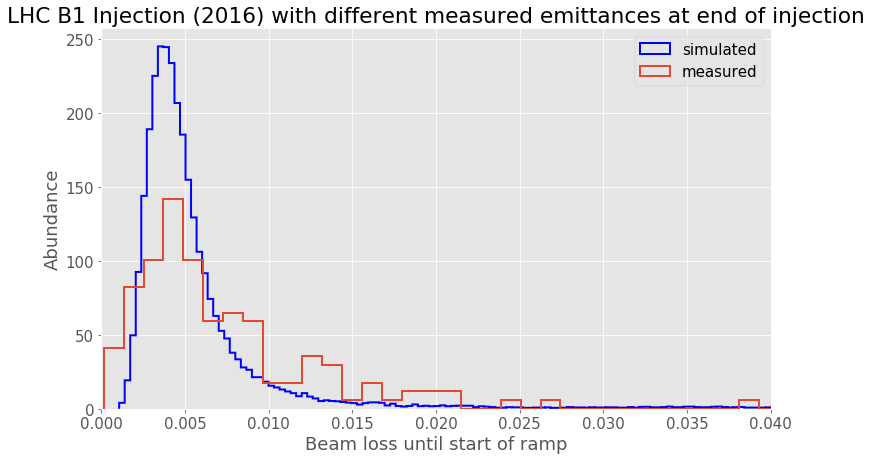

In [24]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=1000,normed=True,histtype='step',label=r'simulated',color='blue',lw=2)
plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=40, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) with different measured emittances at end of injection')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.04)
plt.show()

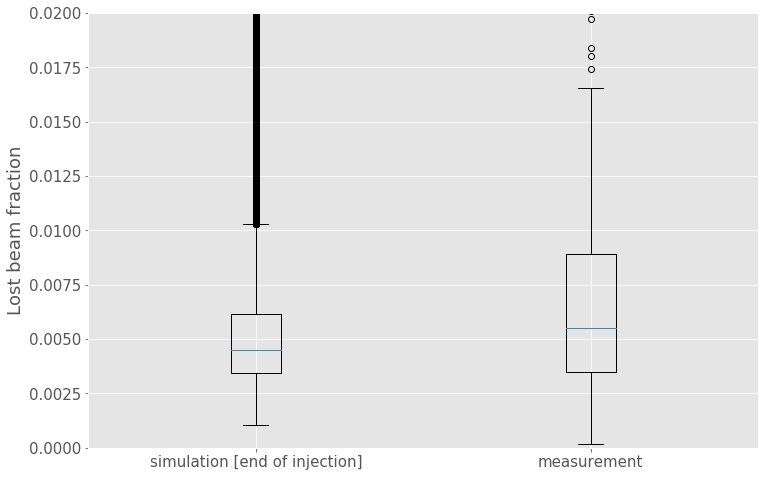

In [25]:
fig = plt.figure(figsize=[12,8])
plt.boxplot([simlss_many,outputb1['experimental']], labels=['simulation [end of injection]','measurement'])
plt.ylabel("Lost beam fraction")
plt.ylim(0,0.02)
plt.show()

## Beam 2

In [64]:
simloss2, outputb2 = np.array([]), []
for i, fill in enumerate(fills[2:]):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b2intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b2intensity])
        length          = end-start
        print('{0}/{1} Fill number: {2}'.format(i,len(fills[2:]),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            outputb2.append([fill,experimental,length])
#             loss = get_loss_from_da(a2, int(length))
#             simloss2 = np.append(simloss2, loss)
    except IndexError:
        pass
outputb2 = pd.DataFrame(outputb2,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


### Use different measured emittances at the end of injection

In [80]:
horizontal_emittances_b2 = np.array([ 1.53948284,  1.67864696,  1.56316953,  1.71615694,  1.64143785,
        1.79540776,  1.71779463,  1.72107172,  1.56000391,  1.71615694,
        1.80207115,  1.65273051,  1.99234046,  1.90141307,  1.60612806,
        1.70961185,  1.80207115,  1.75231757,  1.7391364 ,  1.89971282,
        1.56316953,  1.68189676,  1.72599163,  1.75396778,  1.82546465,
        1.60293173,  1.6721542 ,  1.88443612,  1.80040445,
        1.9218605 ,  1.85739128,  1.70961185,  1.9218605 ,  1.75726989,
        1.70144329,  1.7671899 ,  1.69328895,  1.80207115,  1.66243212,
        1.59176248,  1.7358468 ,  1.84224255,  1.57109353,  1.83720321,
        1.56158644,  1.80207115,  1.77381461,  1.65757876,  1.59973767])

vertical_emittances_b2 = np.array([ 1.24009536,  1.2997237 ,  1.27405631,  1.36026982,  1.27649356,
        1.33668381,  1.28870275,  1.34659795,  1.24734748,  1.45854267,
        1.35653654,  1.32309182,  1.57744346,  1.49953251,  1.30340423,
        1.31077561,  1.28625785,  1.32062552,  1.37149031,  1.52017421,
        1.27405631,  1.35156419,  1.29604661,  1.3540496 ,  1.40911554,
        1.29237296,  1.41668187,  1.43185582,  1.28748011,
        1.53961468,  1.35156419,  1.52017421,  1.53961468,  1.3664996 ,
        1.42426197,  1.26796988,  1.26796988,  1.59056241,  1.28015231,
        1.261893  ,  1.29359713,  1.38524628,  1.23165195,  1.55522898,
        1.31569751,  1.37898783,  1.43439016,  1.22803908,  1.29237296])


emittance = None
fit_params = pd.DataFrame(columns=[u'seed', u'angle', u'emit', u'd', u'b', u'k', u'chi', u'derr', u'berr'])

for j in range(len(horizontal_emittances_b2)):
   
    try:
        print("Reading set {0}/{1} [{2:4.2f}/{3:4.2f}]".format(j+1, len(horizontal_emittances_b2),horizontal_emittances_b2[j],vertical_emittances_b2[j]), end='\r')
        dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
        a1e = da.davst(dbname.format(horizontal_emittances_b2[j],vertical_emittances_b2[j]), emittance)
        dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
        b1e = da.davst(dbname.format(horizontal_emittances_b2[j],vertical_emittances_b2[j]), emittance)
        dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
        c1e = da.davst(dbname.format(horizontal_emittances_b2[j],vertical_emittances_b2[j]), emittance)

#         a1e.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
#         b1e.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
#         c1e.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')

        fit_params = fit_params.append(a1e.fit_params)
        fit_params = fit_params.append(b1e.fit_params)
        fit_params = fit_params.append(c1e.fit_params)
    except:
        pass

    

# a1e.fit_params = a1e.fit_params.reset_index(drop=True)    

# a1e.get_extrapolated_da(minutes=30)
a1e.fit_params = fit_params
a1e.fit_params = a1e.fit_params.reset_index(drop=True) 

a1e.get_extrapolated_da(minutes=30)

Check the mean extrapolated DA

In [83]:
a1e.extrapolated_da['exda_1800_sec'].mean()

7.311050865889756

In [81]:
# selected_dists = distributions[int9<1e-5]
simlss_many = []
for _ in range(5):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800,a1e=a1e))
simlss_many = [item for sublist in simlss_many for item in sublist]  
np.array(simlss_many).mean()

0.001166371191155465

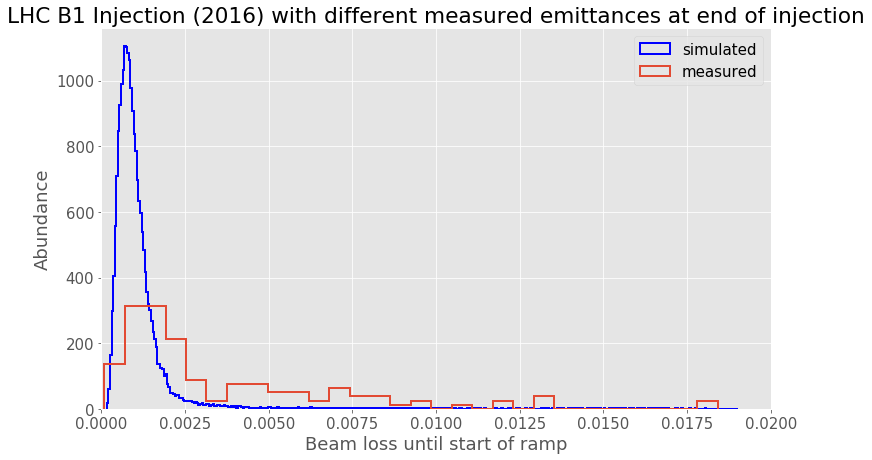

In [69]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=400,normed=True,histtype='step',label=r'simulated',color='blue',lw=2)
plt.hist(outputb2['experimental'][outputb2['experimental']<0.02],normed=True,histtype='step',bins=30, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) with different measured emittances at end of injection')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.02)
plt.show()

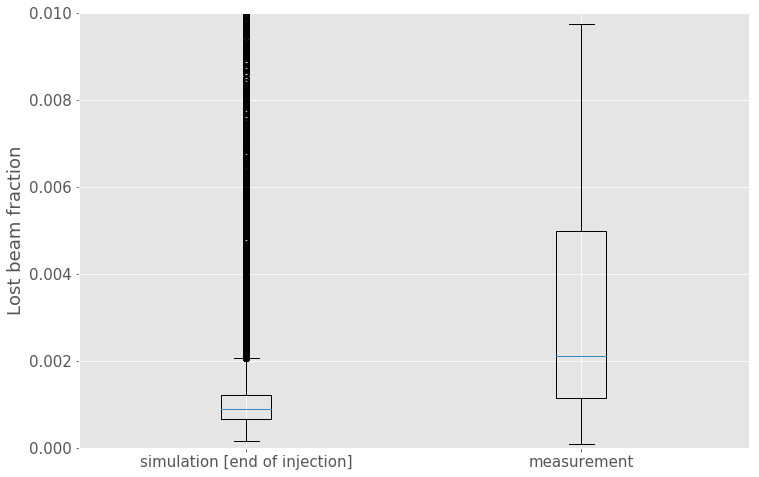

In [70]:
fig = plt.figure(figsize=[12,8])
plt.boxplot([simlss_many,outputb2['experimental']], labels=['simulation [end of injection]','measurement'])
plt.ylabel("Lost beam fraction")
plt.ylim(0,0.01)
plt.show()

If we only take into account the correct chromaticity

In [84]:
emittance = None
fit_params = pd.DataFrame(columns=[u'seed', u'angle', u'emit', u'd', u'b', u'k', u'chi', u'derr', u'berr'])

for j in range(len(horizontal_emittances_b2)):
   
    try:
        print("Reading set {0}/{1} [{2:4.2f}/{3:4.2f}]".format(j+1, len(horizontal_emittances_b2),horizontal_emittances_b2[j],vertical_emittances_b2[j]), end='\r')
        dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
        a1e = da.davst(dbname.format(horizontal_emittances_b2[j],vertical_emittances_b2[j]), emittance)
        dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
        b1e = da.davst(dbname.format(horizontal_emittances_b2[j],vertical_emittances_b2[j]), emittance)
        dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
        c1e = da.davst(dbname.format(horizontal_emittances_b2[j],vertical_emittances_b2[j]), emittance)

#         a1e.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
#         b1e.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
#         c1e.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')

        fit_params = fit_params.append(a1e.fit_params)
#         fit_params = fit_params.append(b1e.fit_params)
#         fit_params = fit_params.append(c1e.fit_params)
    except:
        pass

    

# a1e.fit_params = a1e.fit_params.reset_index(drop=True)    

# a1e.get_extrapolated_da(minutes=30)
a1e.fit_params = fit_params
a1e.fit_params = a1e.fit_params.reset_index(drop=True) 

a1e.get_extrapolated_da(minutes=30)

In [85]:
a1e.extrapolated_da['exda_1800_sec'].mean()

7.3595714838966435

In [87]:
# selected_dists = distributions[int9<1e-5]
simlss_many = []
for _ in range(50):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800,a1e=a1e))
simlss_many = [item for sublist in simlss_many for item in sublist]  
np.array(simlss_many).mean()

0.00099862521495764516

In [ ]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=50,normed=True,histtype='step',label=r'simulated',color='blue',lw=2)
plt.hist(outputb2['experimental'][outputb2['experimental']<0.02],normed=True,histtype='step',bins=30, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) with different measured emittances at end of injection')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.02)
plt.show()

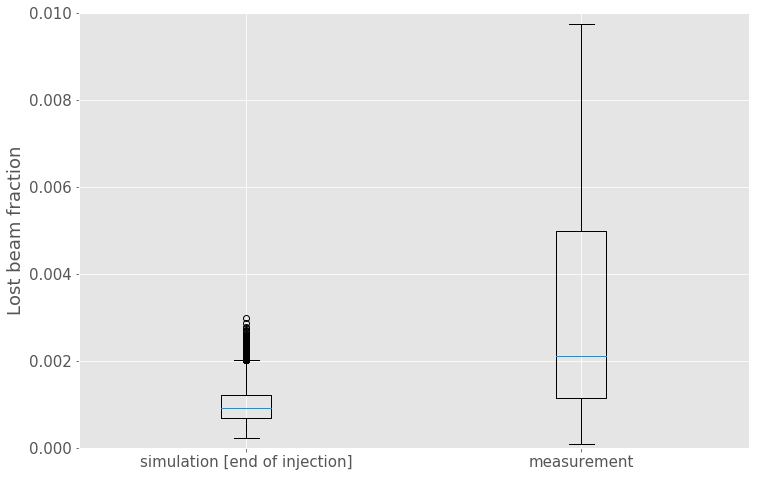

In [77]:
fig = plt.figure(figsize=[12,8])
plt.boxplot([simlss_many,outputb2['experimental']], labels=['simulation [end of injection]','measurement'])
plt.ylabel("Lost beam fraction")
plt.ylim(0,0.01)
plt.show()

### Use mean emittances 

In [ ]:
emittance = None
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
a1s = da.davst(dbname.format(1.66,1.32), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
b1s = da.davst(dbname.format(1.66,1.32), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
c1s = da.davst(dbname.format(1.66,1.32), emittance)

for database in [a1s,b1s,c1s]:
    database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1s.fit_params = a1s.fit_params.append(b1s.fit_params)
a1s.fit_params = a1s.fit_params.append(c1s.fit_params)
a1s.fit_params = a1s.fit_params.reset_index(drop=True)    

a1s.get_extrapolated_da(minutes=30)

sixdesk/da.py:298: RuntimeWarning: invalid value encountered in log10
  da = d + (b / (np.log10(turn) ** kappa))
sixdesk/da.py:298: RuntimeWarning: invalid value encountered in power
  da = d + (b / (np.log10(turn) ** kappa))


In [227]:
emittance = None
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
a1e = da.davst(dbname.format(1.76,1.39), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
b1e = da.davst(dbname.format(1.76,1.39), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
c1e = da.davst(dbname.format(1.76,1.39), emittance)

for database in [a1e,b1e,c1e]:
    database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1e.fit_params = a1e.fit_params.append(b1e.fit_params)
a1e.fit_params = a1e.fit_params.append(c1e.fit_params)
a1e.fit_params = a1e.fit_params.reset_index(drop=True)    

a1e.get_extrapolated_da(minutes=30)

In [283]:
simlss_many = []
for _ in range(196):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800,a1e=a1s))
simlss_many = [item for sublist in simlss_many for item in sublist]  

In [284]:
simlss_manye = []
for _ in range(196):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_manye.append(get_loss_for_dist(d,1800,a1e=a1e))
simlss_manye = [item for sublist in simlss_manye for item in sublist]  

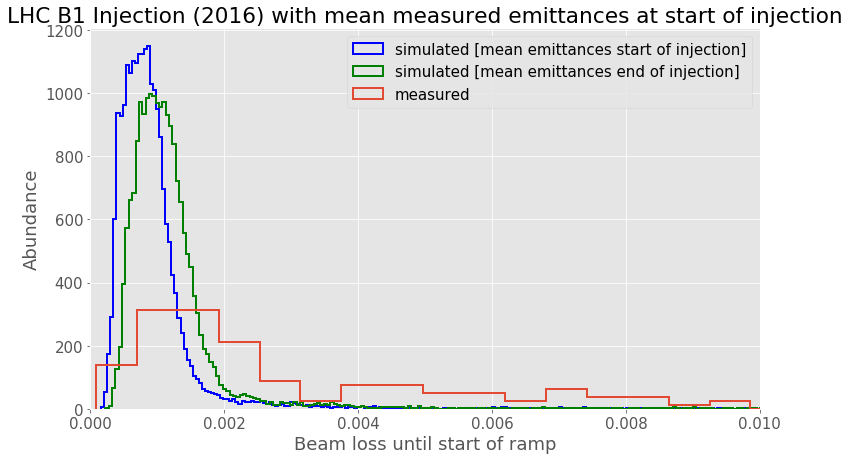

In [286]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=400,normed=True,histtype='step',label=r'simulated [mean emittances start of injection]',color='blue',lw=2)
plt.hist(simlss_manye,bins=400,normed=True,histtype='step',label=r'simulated [mean emittances end of injection]',color='green',lw=2)

plt.hist(outputb2['experimental'][outputb2['experimental']<0.02],normed=True,histtype='step',bins=30, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) with mean measured emittances at start of injection')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.01)
plt.show()

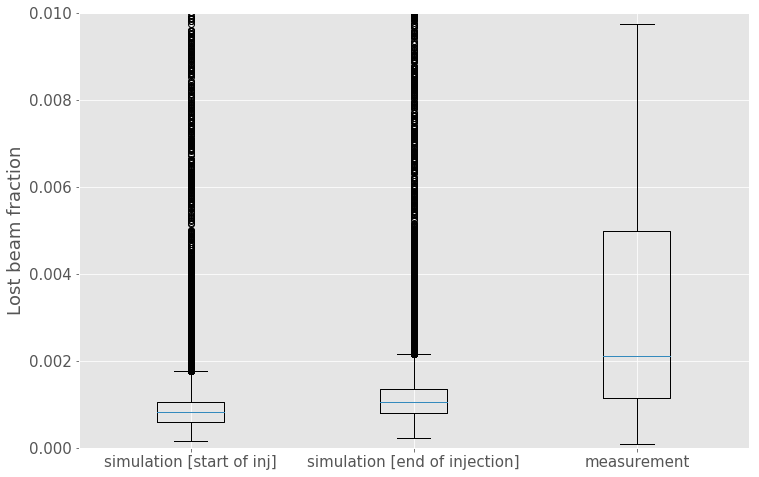

In [287]:
fig = plt.figure(figsize=[12,8])
plt.boxplot([simlss_many,simlss_manye,outputb2['experimental']], labels=['simulation [start of inj]', 'simulation [end of injection]','measurement'])
plt.ylabel("Lost beam fraction")
plt.ylim(0,0.01)
plt.show()

# ATS 2017

In [26]:
dbname = '/media/phermes/local/DA_studies/ats2017/db/ats2017_b1_QP_{0}_IOCT_{1}.db'
a1 = da.davst(dbname.format(20,40), 2.2)
b1 = da.davst(dbname.format(18,40), 2.2)
c1 = da.davst(dbname.format(16,40), 2.2)

a1.fit_params = a1.fit_params.append(b1.fit_params)
a1.fit_params = a1.fit_params.append(c1.fit_params)
a1.fit_params = a1.fit_params.reset_index(drop=True)

dbname = '/media/phermes/local/DA_studies/ats2017/db/ats2017_b2_QP_{0}_IOCT_{1}.db'
a2 = da.davst(dbname.format(20,40), 2.2)
b2 = da.davst(dbname.format(18,40), 2.2)
c2 = da.davst(dbname.format(16,40), 2.2)

a2.fit_params = a2.fit_params.append(b2.fit_params)
a2.fit_params = a2.fit_params.append(c2.fit_params)
a2.fit_params = a2.fit_params.reset_index(drop=True)

def get_loss_from_da(a, seconds):
    a.get_extrapolated_da(seconds=seconds,realizations=10)
    daseries = a.extrapolated_da['exda_{0}_sec'.format(seconds)]
    return bl.get_loss_from_da_series(daseries)

In [14]:
df = pd.read_csv('/home/phermes/Desktop/exportedCSV-1.csv')
fills = df['Fill Number']

In [15]:
fills1 = fills[fills<6270]

In [16]:
fills2 = fills[fills>6270]

In [17]:
len(fills), len(fills1), len(fills2)

(235, 163, 72)

In [18]:
simloss1, outputb1 = np.array([]), []
for i, fill in enumerate(fills1):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b1intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b1intensity])
        length          = end-start
        print('{0}/{1} Fill number: {2}'.format(i,len(fills1),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            outputb1.append([fill,experimental,length])
#             loss = get_loss_from_da(a1, int(length))
#             simloss1 = np.append(simloss1, loss)
    except IndexError:
        pass
outputb1 = pd.DataFrame(outputb1,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


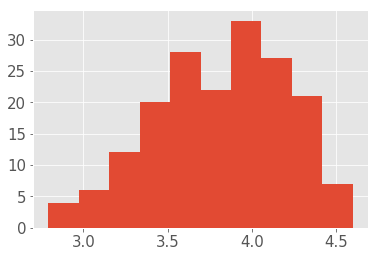

In [39]:
emittance = None
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2017_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
a1 = da.davst(dbname.format(1.83,1.77), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2017_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
b1 = da.davst(dbname.format(1.83,1.77), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2017_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
c1 = da.davst(dbname.format(1.83,1.77), emittance)

# for database in [a1s,b1s,c1s]:
#     database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1.fit_params = a1.fit_params.append(b1.fit_params)
a1.fit_params = a1.fit_params.append(c1.fit_params)
a1.fit_params = a1.fit_params.reset_index(drop=True)    

a1.get_extrapolated_da(minutes=30)

a1.extrapolated_da['exda_1800_sec'].hist()
plt.show()

In [24]:
selected_dists = distributions[int9<1e-5]

simlss_many = []
for _ in range(100):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800,a1e=a1))
simlss_many = [item for sublist in simlss_many for item in sublist]  

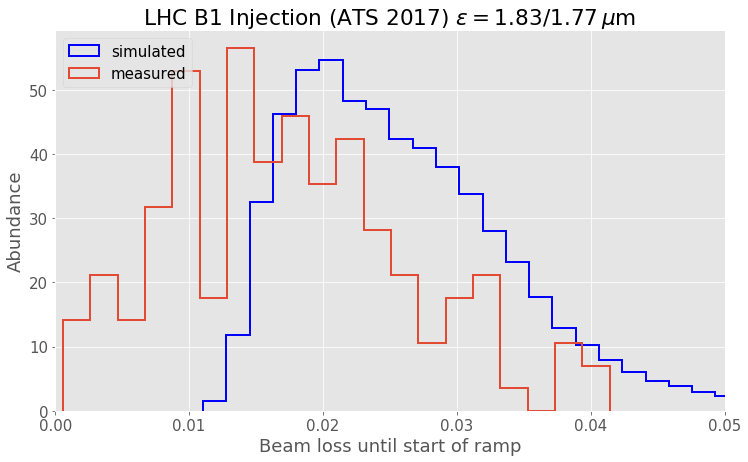

In [27]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=30,normed=True,histtype='step',label='simulated',color='blue',lw=2)
plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B1 Injection (ATS 2017) $\epsilon=1.83/1.77\,\mu$m')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

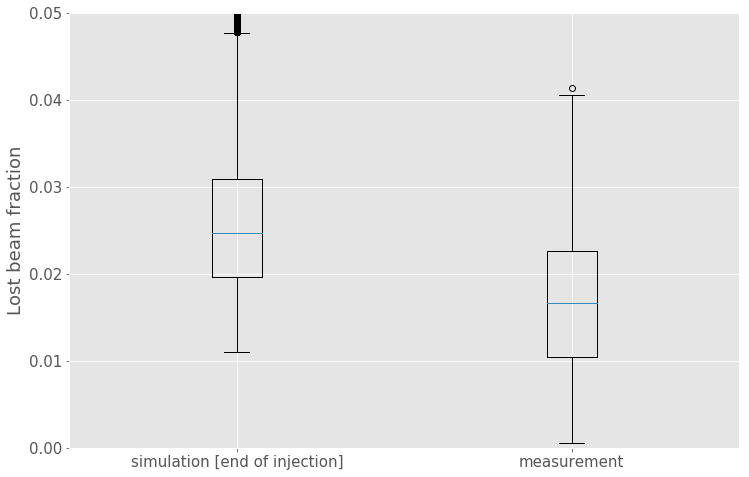

In [28]:
fig = plt.figure(figsize=[12,8])
plt.boxplot([simlss_many,outputb1['experimental']], labels=['simulation [end of injection]','measurement'])
plt.ylabel("Lost beam fraction")
plt.ylim(0,0.05)
plt.show()

In [40]:
emittance = None
ex,ey = 1.12, 1.10
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2017_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
a1 = da.davst(dbname.format(ex, ey), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2017_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
b1 = da.davst(dbname.format(ex, ey), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2017_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
c1 = da.davst(dbname.format(ex, ey), emittance)

# for database in [a1,b1,c1]:
#     database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1.fit_params = a1.fit_params.append(b1.fit_params)
a1.fit_params = a1.fit_params.append(c1.fit_params)
a1.fit_params = a1.fit_params.reset_index(drop=True)    

a1.get_extrapolated_da(minutes=30)

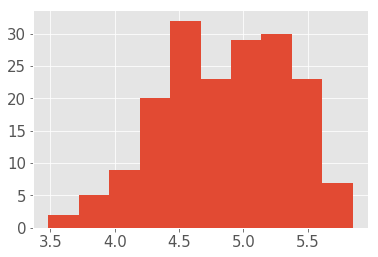

In [45]:
a1.extrapolated_da['exda_1800_sec'].hist()
plt.show()

In [46]:
simloss1, outputb1 = np.array([]), []
for i, fill in enumerate(fills2):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b1intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b1intensity])
        length          = end-start
        print('{0}/{1} Fill number: {2}'.format(i,len(fills2),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            outputb1.append([fill,experimental,length])
#             loss = get_loss_from_da(a1, int(length))
#             simloss1 = np.append(simloss1, loss)
    except IndexError:
        pass
outputb1 = pd.DataFrame(outputb1,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


In [47]:
selected_dists = distributions[int9<1e-5]
simlss_many = []
for _ in range(100):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800,a1e=a1))
simlss_many = [item for sublist in simlss_many for item in sublist]  

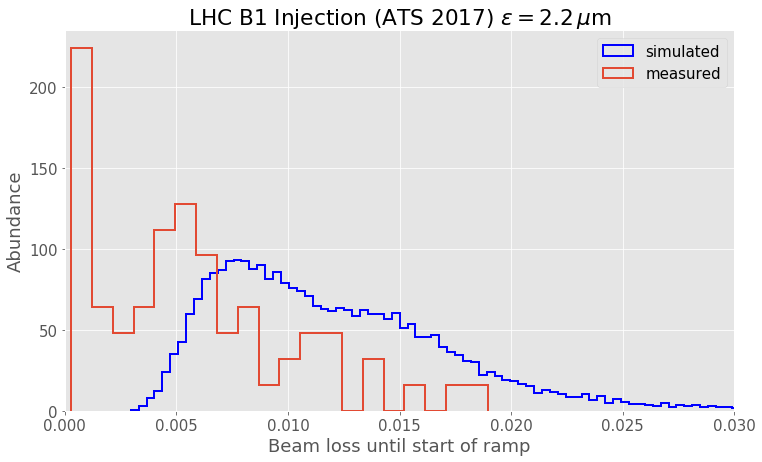

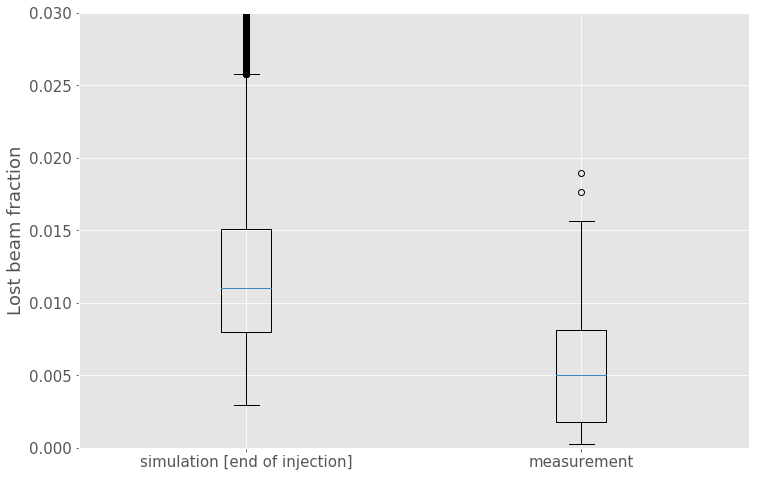

In [48]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=100,normed=True,histtype='step',label='simulated',color='blue',lw=2)
plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B1 Injection (ATS 2017) $\epsilon=2.2\,\mu$m')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.03)
plt.show()

fig = plt.figure(figsize=[12,8])
plt.boxplot([simlss_many,outputb1['experimental']], labels=['simulation [end of injection]','measurement'])
plt.ylabel("Lost beam fraction")
plt.ylim(0,0.03)
plt.show()

## Beam 2

#### Fill< 6270

In [54]:
simloss2, outputb2 = np.array([]), []
for i, fill in enumerate(fills1):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b2intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b2intensity])
        length          = end-start
        print('{0}/{1} Fill number: {2}'.format(i,len(fills1),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            outputb2.append([fill,experimental,length])
#             loss = get_loss_from_da(a2, int(length))
#             simloss2 = np.append(simloss2, loss)
    except IndexError:
        pass
outputb2 = pd.DataFrame(outputb2,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


In [56]:
emittance = None
ex,ey = 1.87, 1.77
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2017_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
a1 = da.davst(dbname.format(ex, ey), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2017_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
b1 = da.davst(dbname.format(ex, ey), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2017_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
c1 = da.davst(dbname.format(ex, ey), emittance)

for database in [a1,b1,c1]:
    database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1.fit_params = a1.fit_params.append(b1.fit_params)
a1.fit_params = a1.fit_params.append(c1.fit_params)
a1.fit_params = a1.fit_params.reset_index(drop=True)    

a1.get_extrapolated_da(minutes=30)

In [57]:
selected_dists = distributions[int9<1e-5]
simlss_many = []
for _ in range(100):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800,a1e=a1))
simlss_many = [item for sublist in simlss_many for item in sublist]  

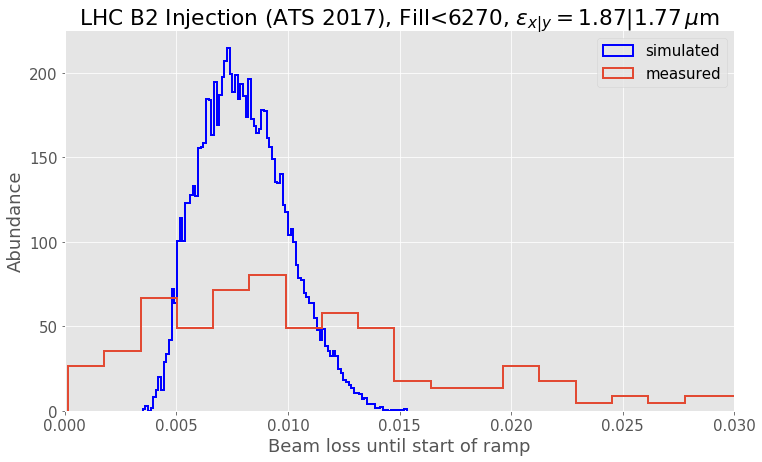

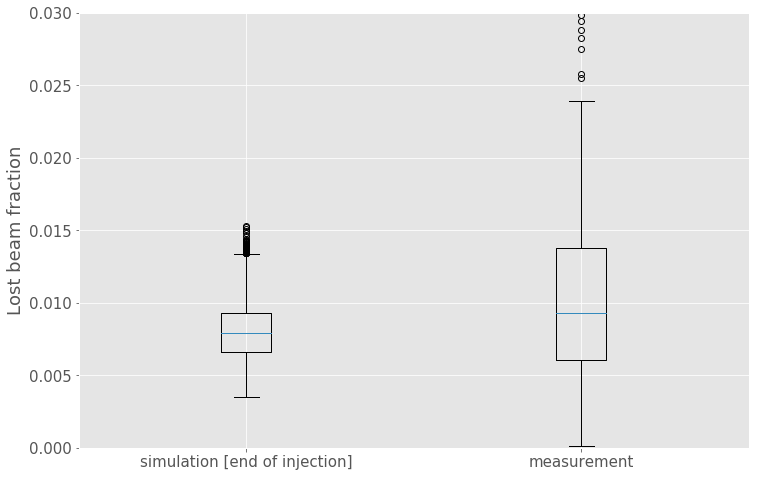

In [62]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=100,normed=True,histtype='step',label='simulated',color='blue',lw=2)
plt.hist(outputb2['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B2 Injection (ATS 2017), Fill<6270, $\epsilon_{x|y}=1.87|1.77\,\mu$m')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.03)
plt.show()

fig = plt.figure(figsize=[12,8])
plt.boxplot([simlss_many,outputb2['experimental']], labels=['simulation [end of injection]','measurement'])
plt.ylabel("Lost beam fraction")
plt.ylim(0,0.03)
plt.show()

#### Fill>6270

In [65]:
simloss2, outputb2 = np.array([]), []
for i, fill in enumerate(fills2):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b2intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b2intensity])
        length          = end-start
        print('{0}/{1} Fill number: {2}'.format(i+1,len(fills2),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            outputb2.append([fill,experimental,length])
#             loss = get_loss_from_da(a2, int(length))
#             simloss2 = np.append(simloss2, loss)
    except IndexError:
        pass
outputb2 = pd.DataFrame(outputb2,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


In [66]:
emittance = None
ex,ey = 1.15, 1.08
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2017_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
a1 = da.davst(dbname.format(ex, ey), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2017_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
b1 = da.davst(dbname.format(ex, ey), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2017_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
c1 = da.davst(dbname.format(ex, ey), emittance)

for database in [a1,b1,c1]:
    database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1.fit_params = a1.fit_params.append(b1.fit_params)
a1.fit_params = a1.fit_params.append(c1.fit_params)
a1.fit_params = a1.fit_params.reset_index(drop=True)    

a1.get_extrapolated_da(minutes=30)

In [67]:
selected_dists = distributions[int9<1e-5]
simlss_many = []
for _ in range(100):
    j = np.random.randint(len(selected_dists))
    distr = selected_dists.iloc[j]
    d = dgauss(distr['a1'], 1.0, distr['sig2'])
    simlss_many.append(get_loss_for_dist(d,1800,a1e=a1))
simlss_many = [item for sublist in simlss_many for item in sublist]  

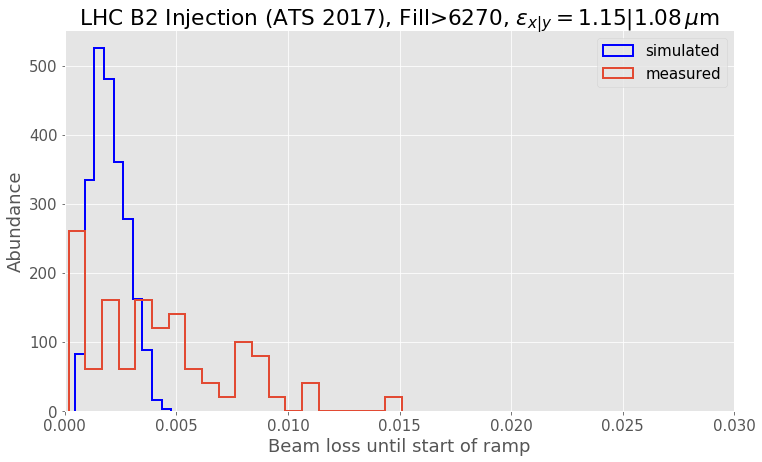

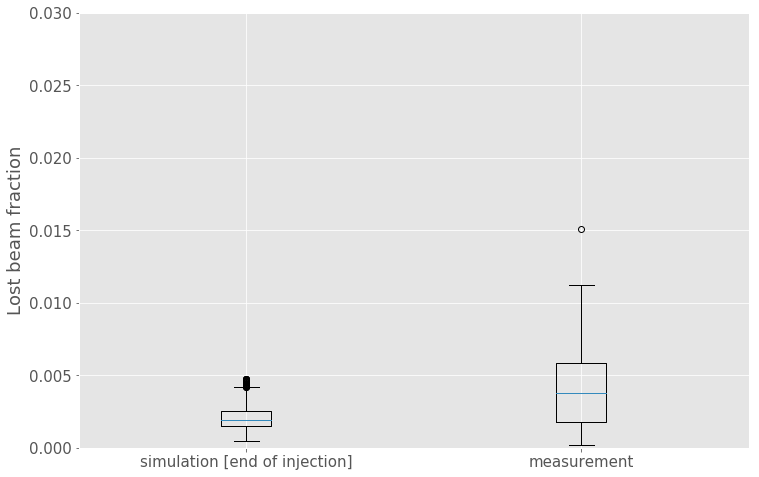

In [70]:
fig = plt.figure(figsize=[12,7])
plt.hist(simlss_many,bins=10,normed=True,histtype='step',label='simulated',color='blue',lw=2)
plt.hist(outputb2['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B2 Injection (ATS 2017), Fill>6270, $\epsilon_{x|y}=1.15|1.08\,\mu$m')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.03)
plt.show()

fig = plt.figure(figsize=[12,8])
plt.boxplot([simlss_many,outputb2['experimental']], labels=['simulation [end of injection]','measurement'])
plt.ylabel("Lost beam fraction")
plt.ylim(0,0.03)
plt.show()

# Use bunch by bunch intensity [DEV]

In [108]:
db.search("LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY")

[u'LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY']

In [109]:
simloss, outputb1 = [], []
for fill in fills[2:]:
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get(["LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY"],start,end)
    except:
        continue
    break

In [110]:
bb = data['LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY'][1][-1]

In [111]:
len(bb)

3564

35640 buckets 

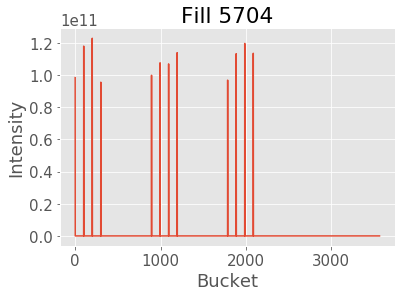

In [112]:
plt.plot(np.arange(1,len(bb)+1),bb)
plt.title("Fill {0}".format(fill))
plt.xlabel("Bucket")
plt.ylabel("Intensity")
plt.show()

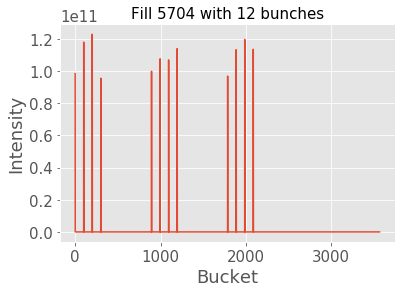

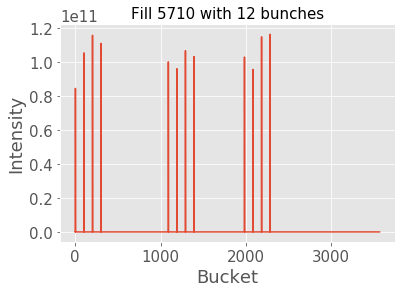

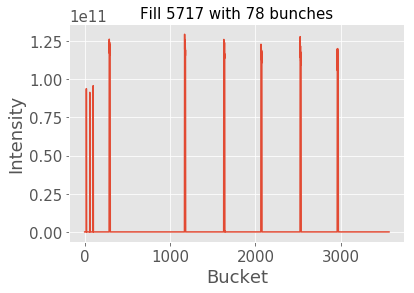

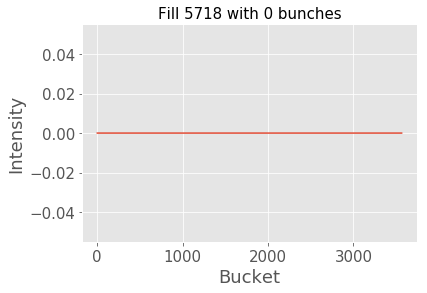

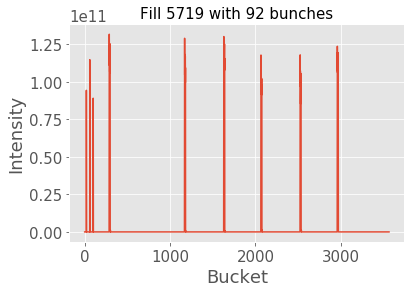

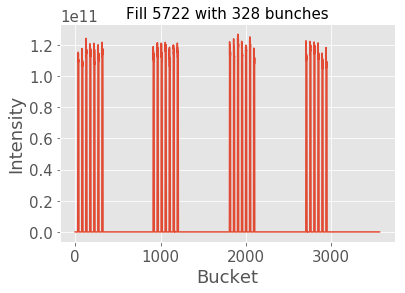

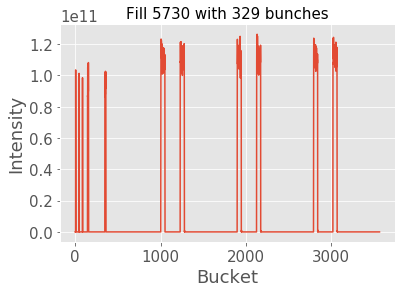

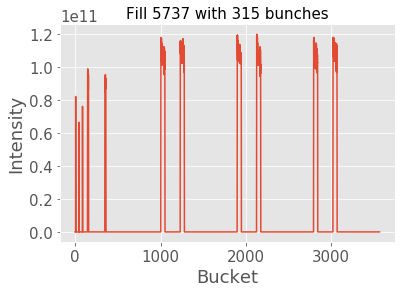

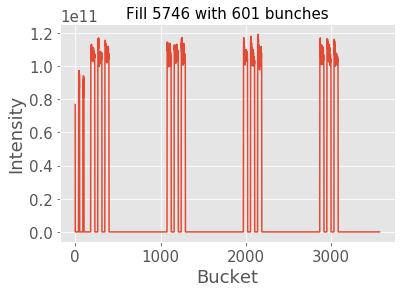

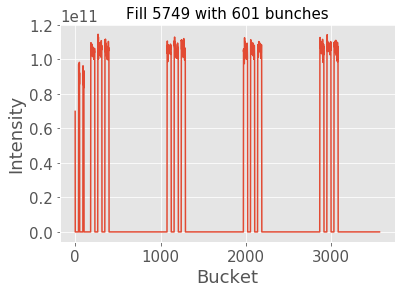

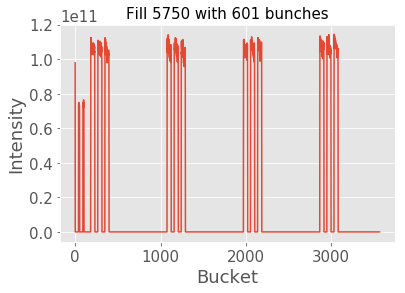

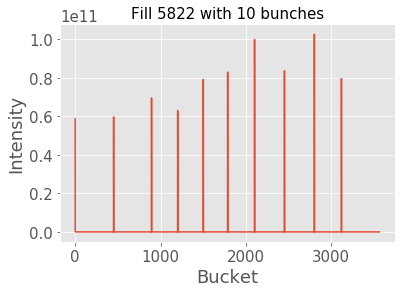

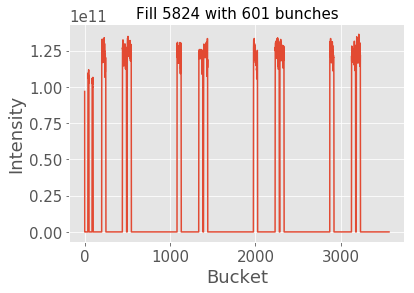

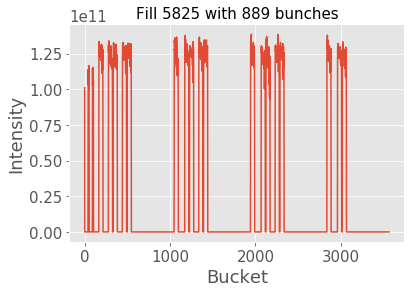

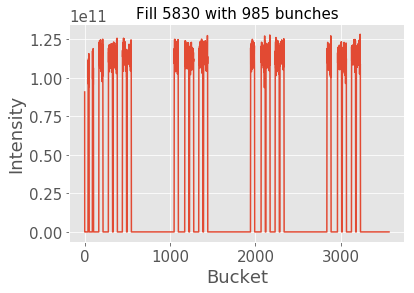

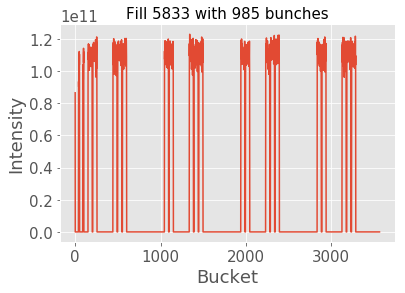

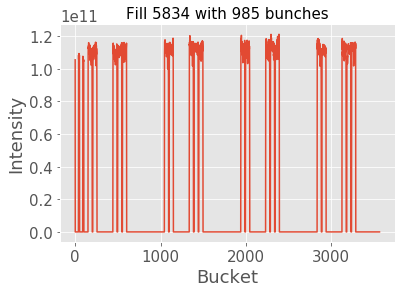

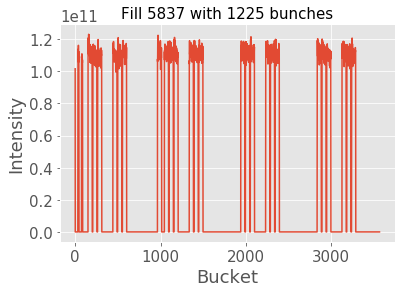

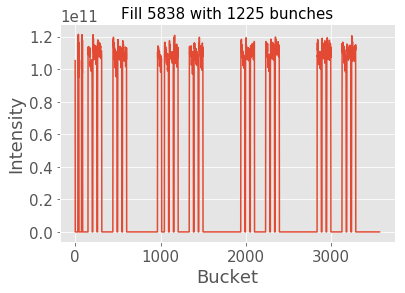

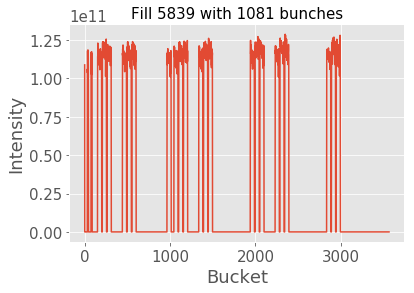

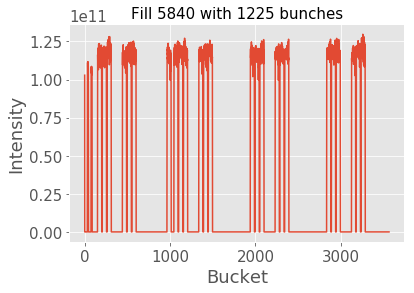

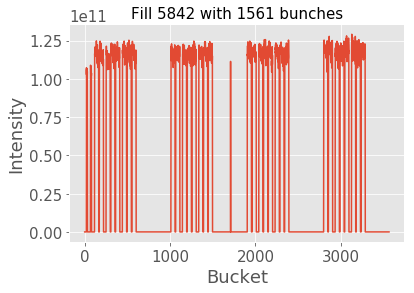

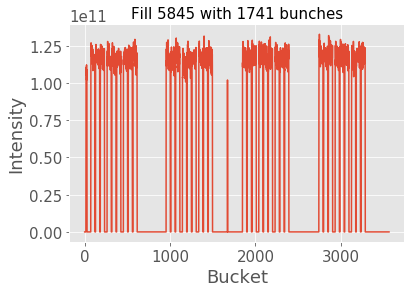

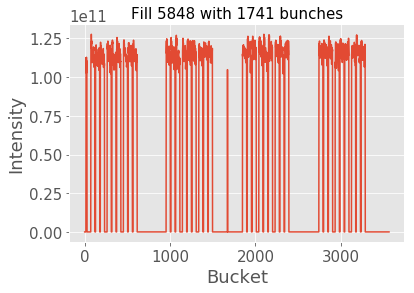

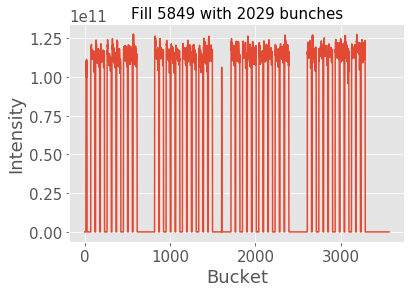

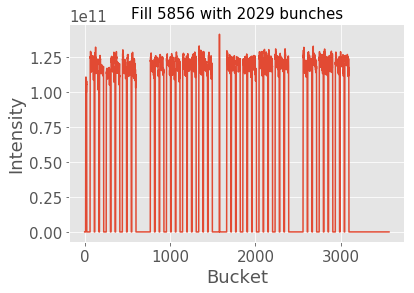

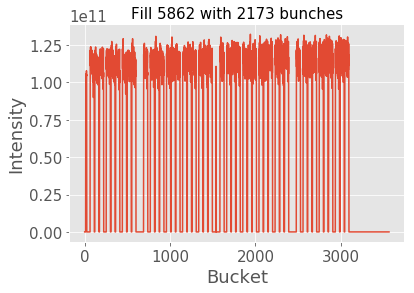

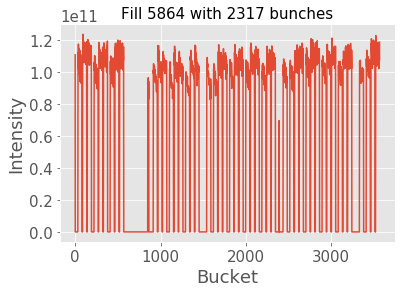

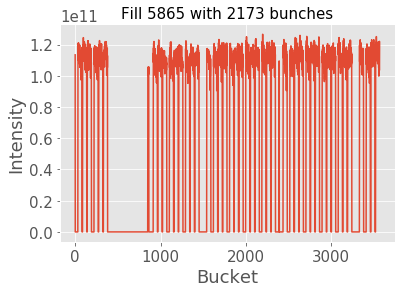

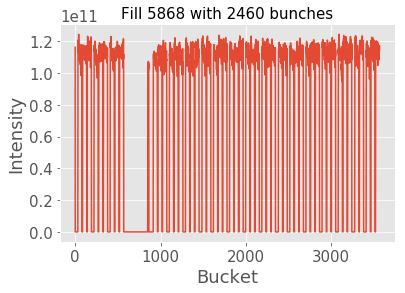

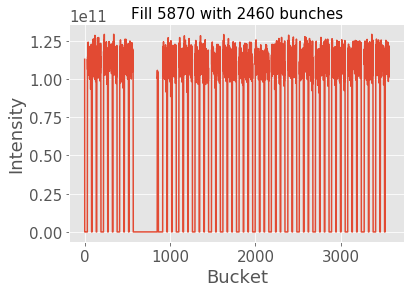

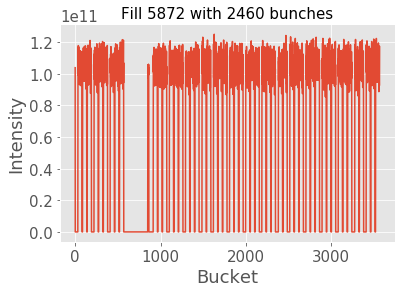

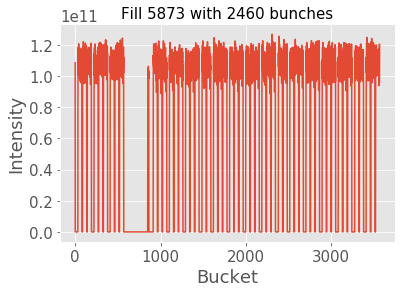

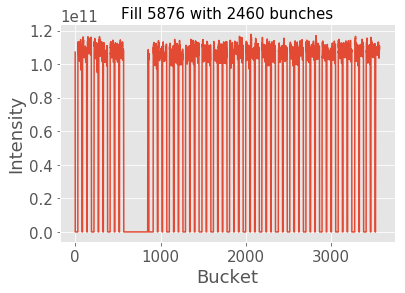

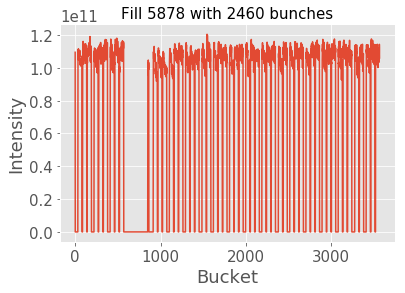

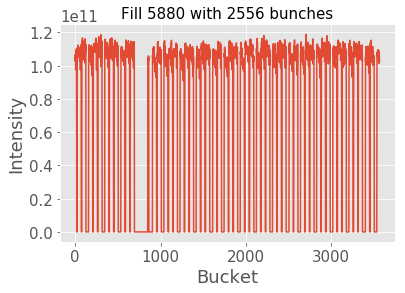

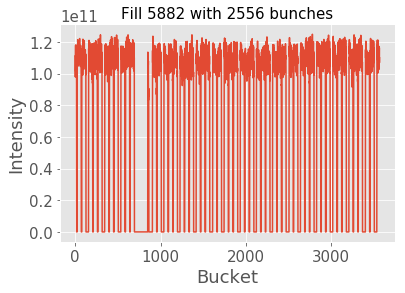

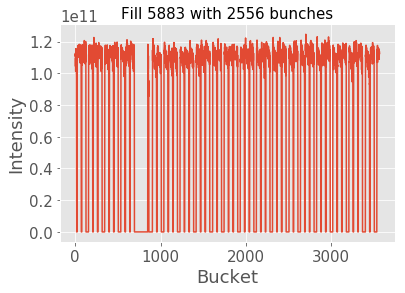

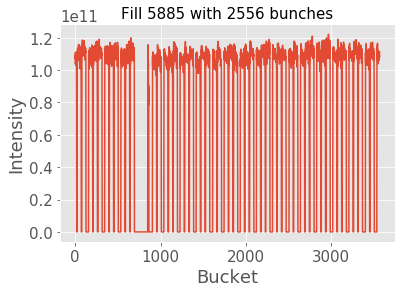

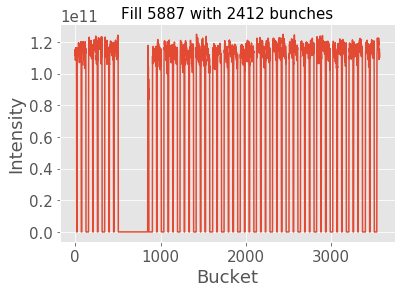

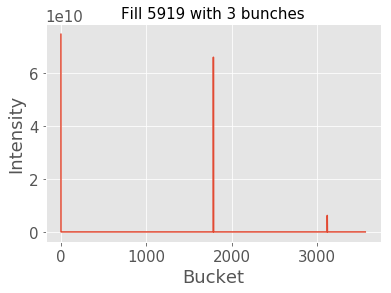

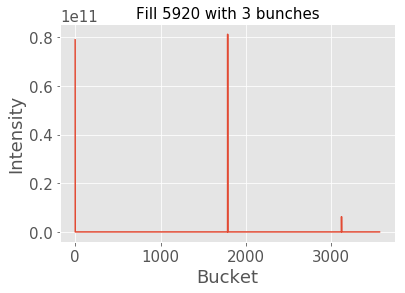

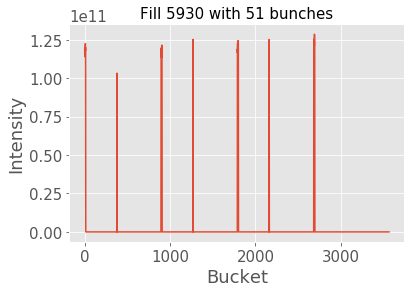

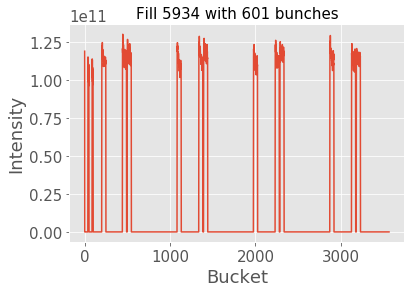

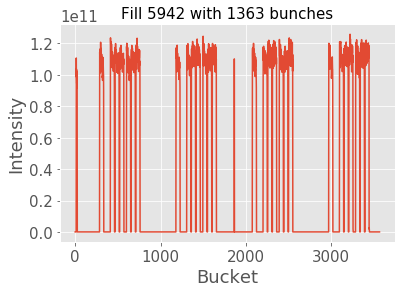

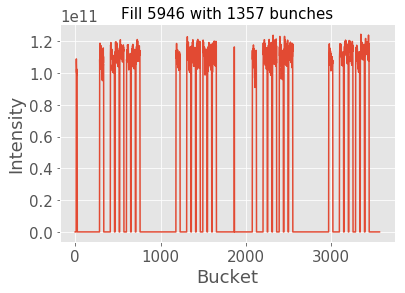

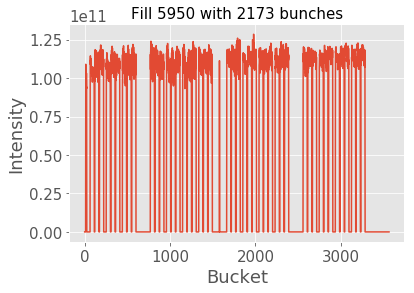

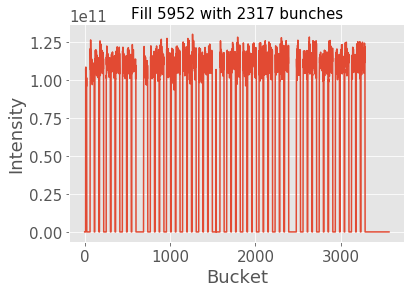

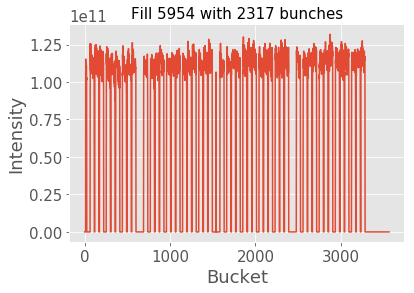

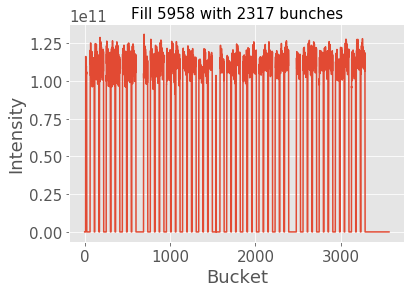

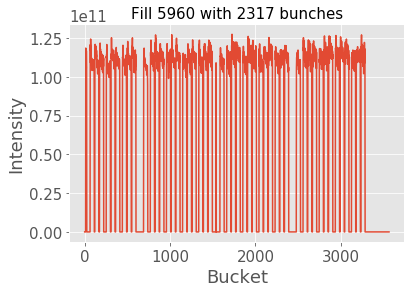

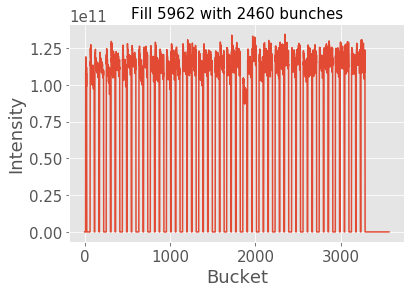

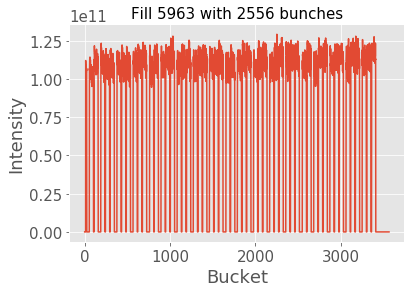

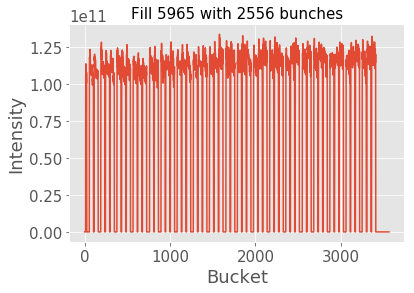

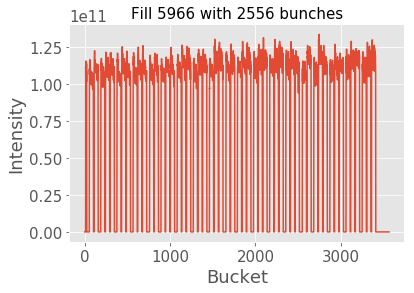

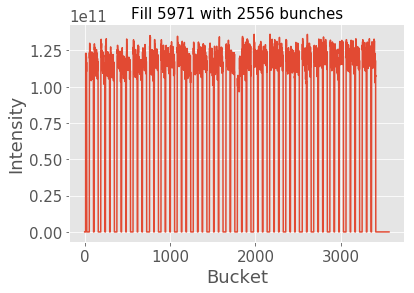

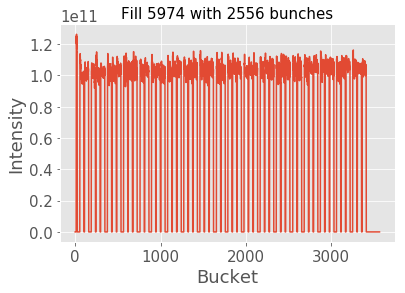

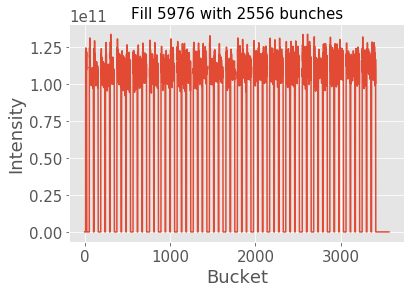

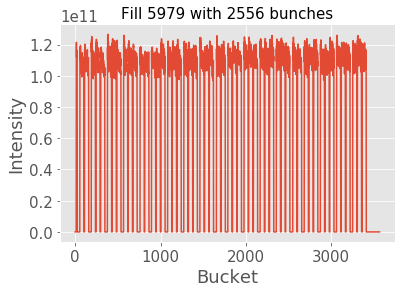

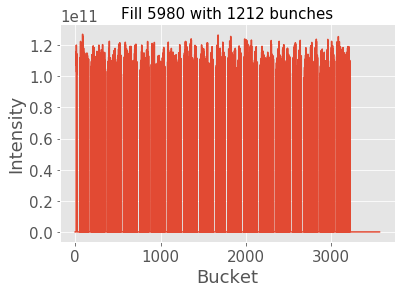

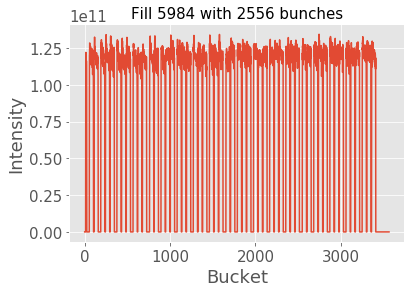

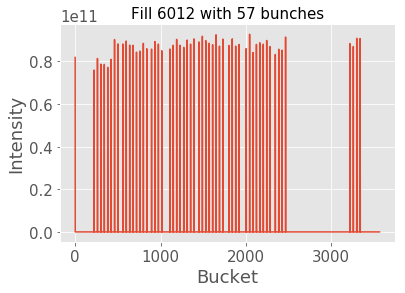

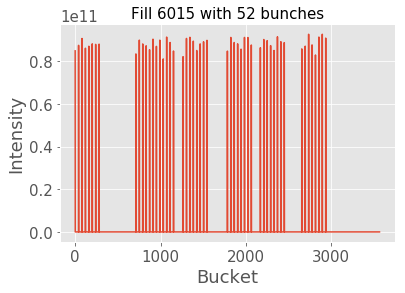

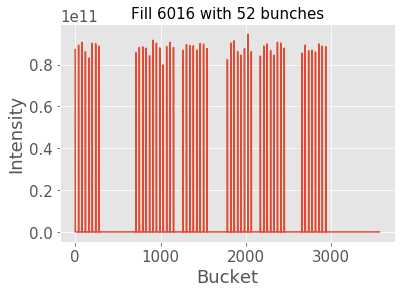

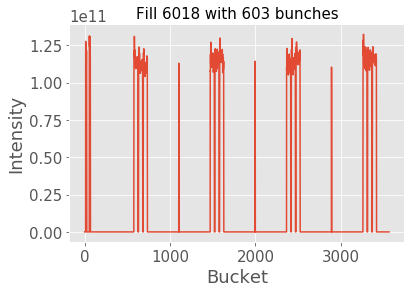

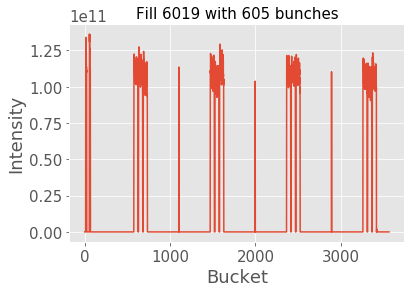

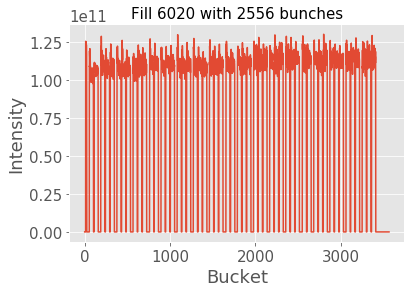

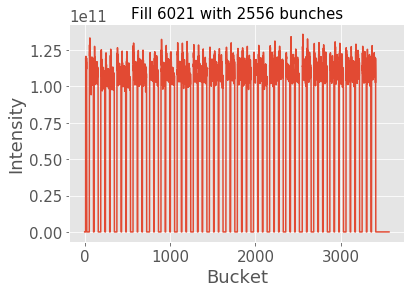

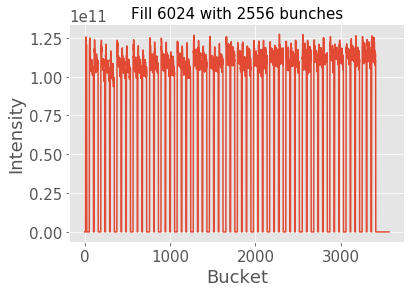

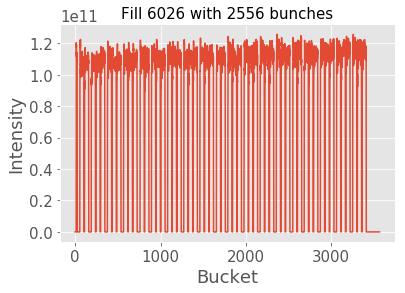

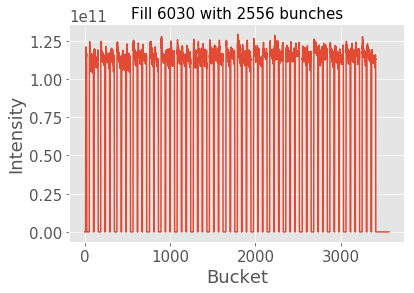

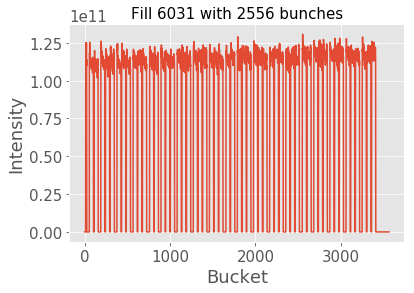

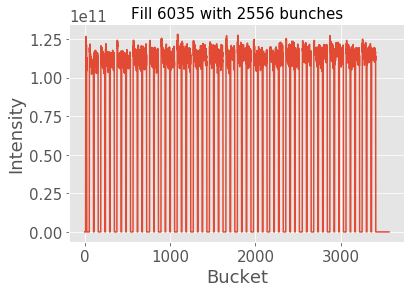

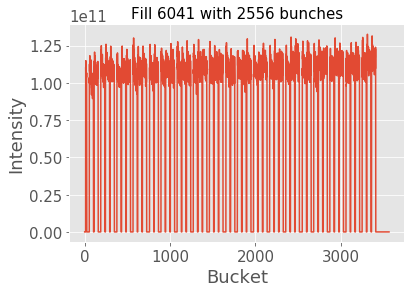

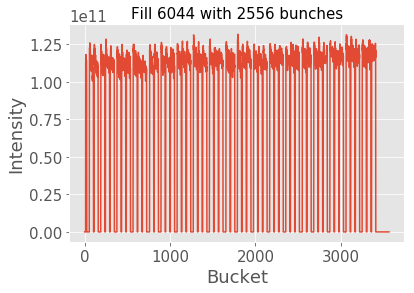

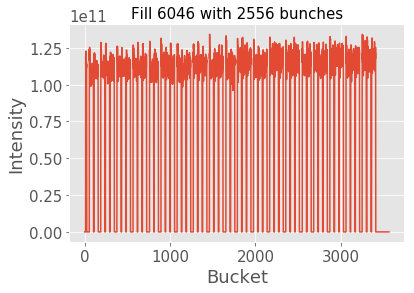

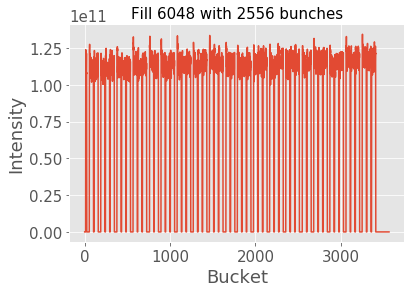

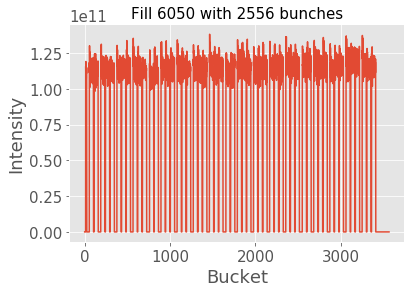

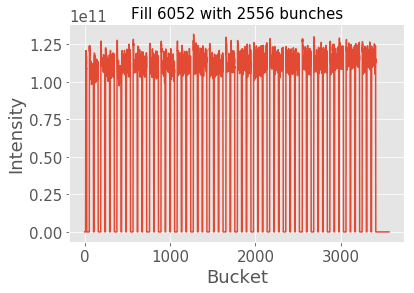

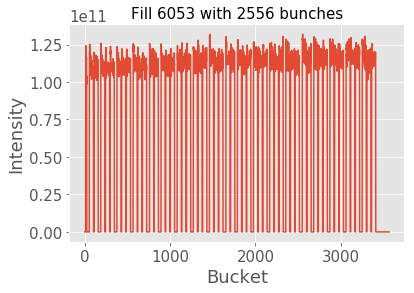

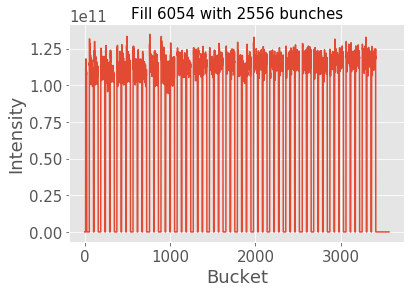

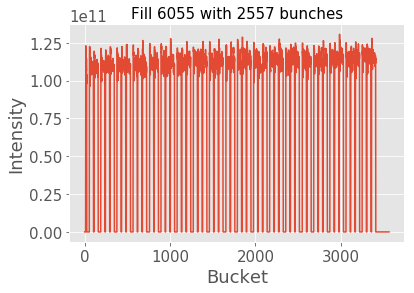

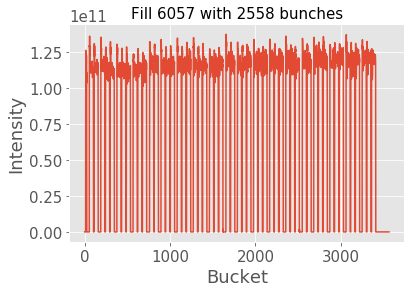

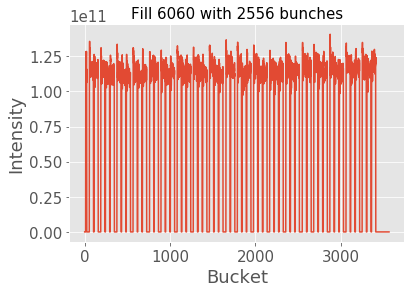

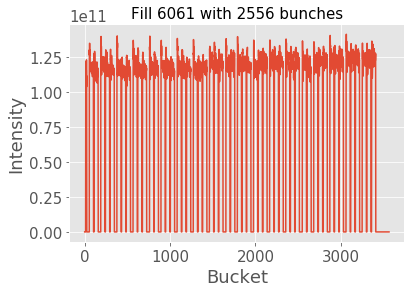

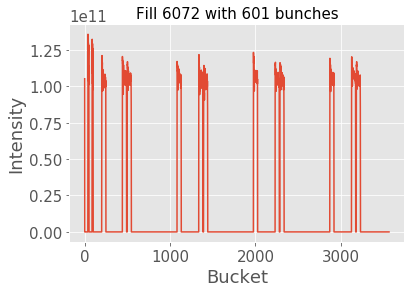

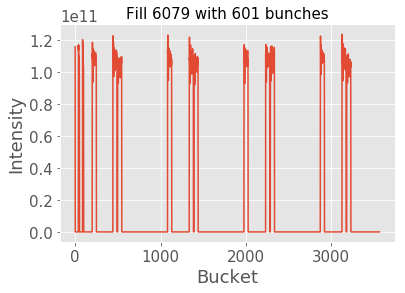

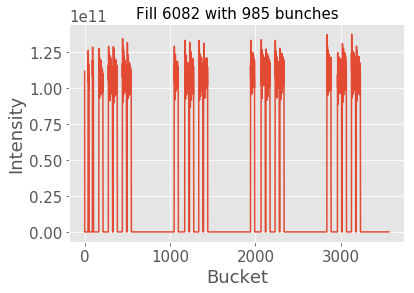

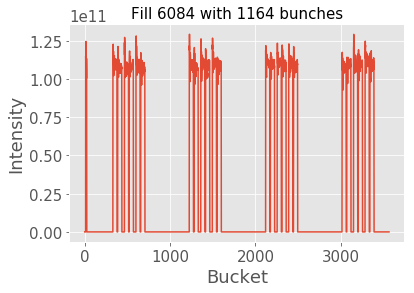

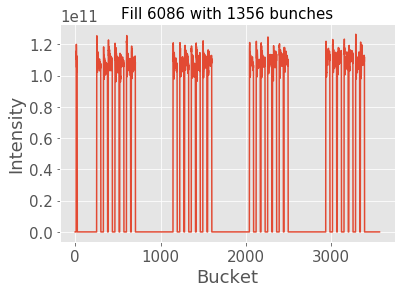

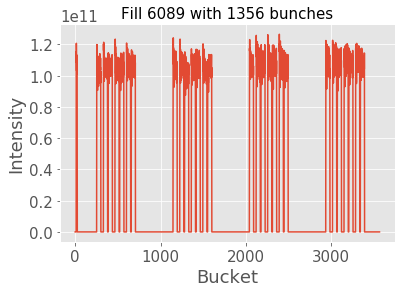

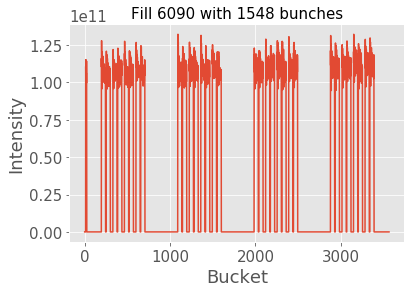

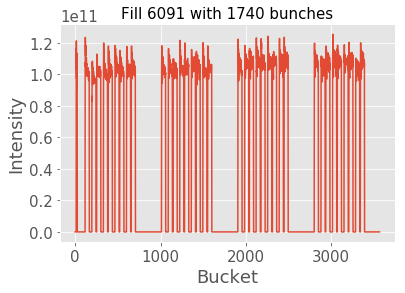

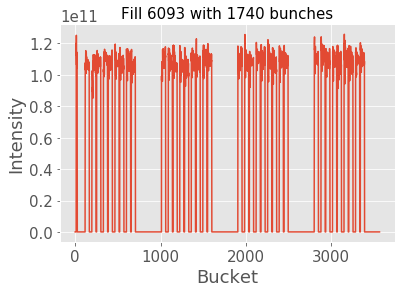

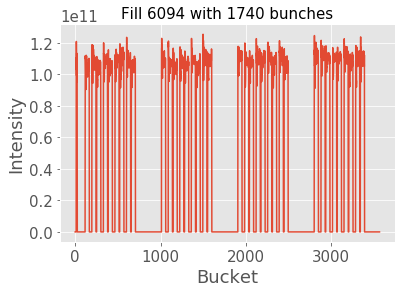

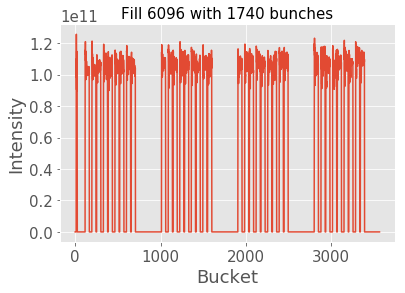

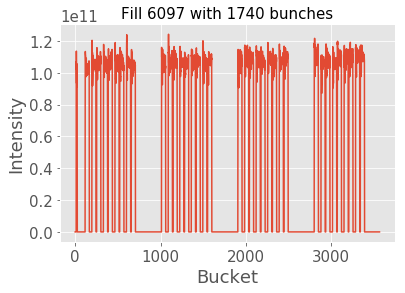

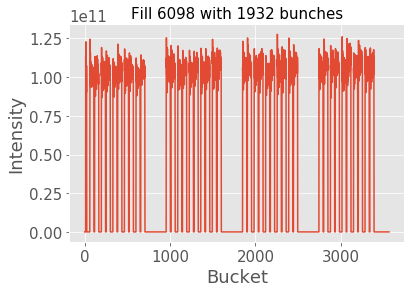

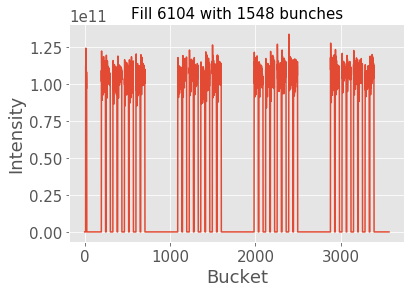

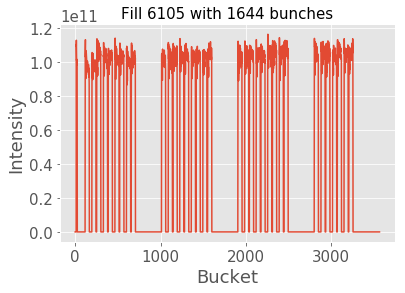

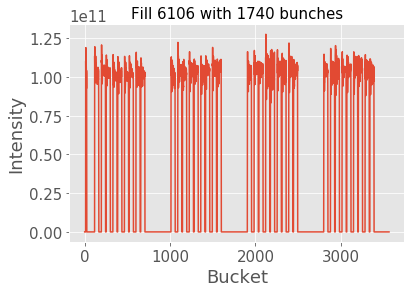

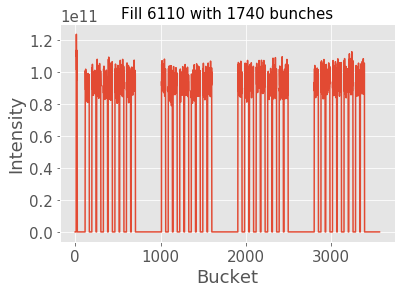

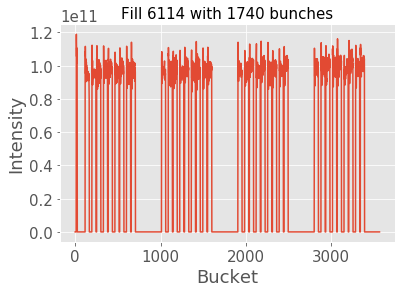

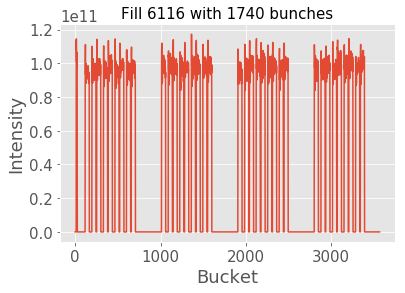

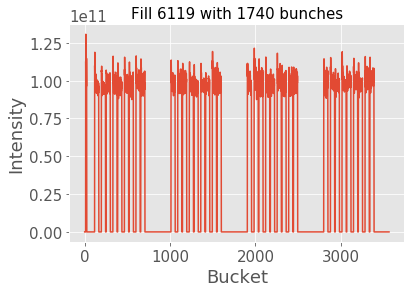

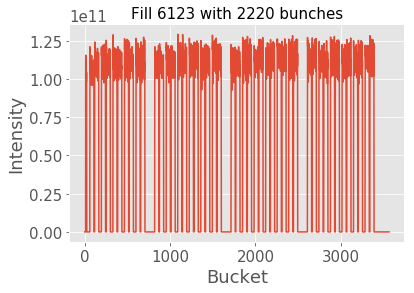

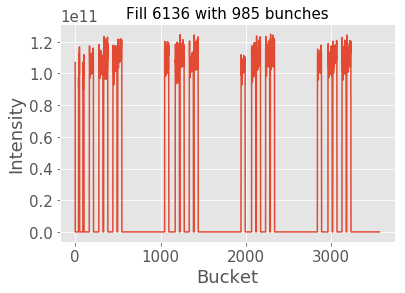

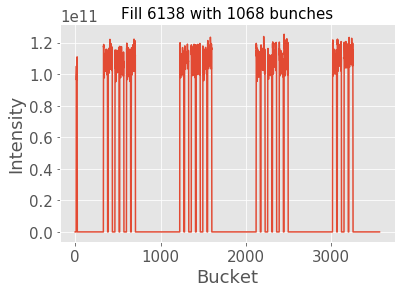

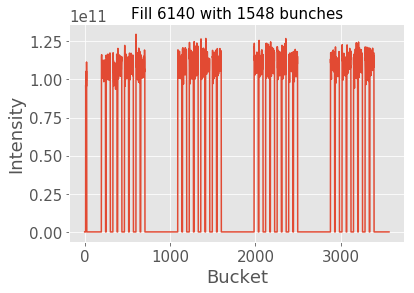

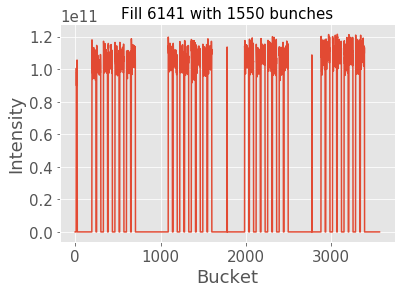

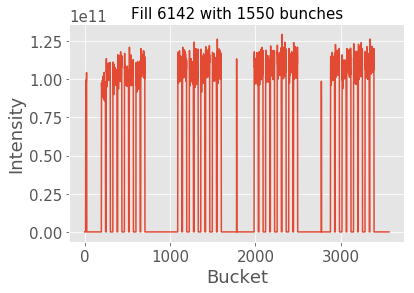

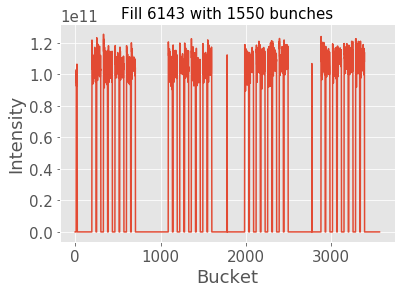

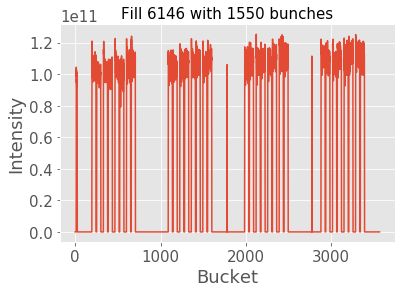

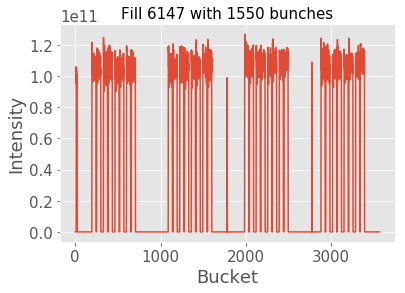

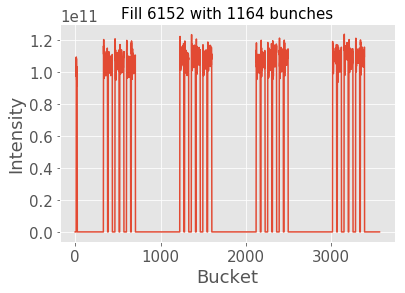

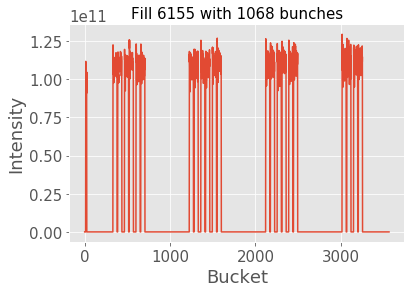

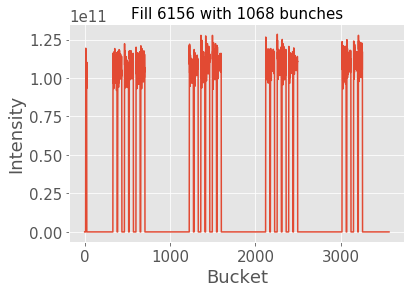

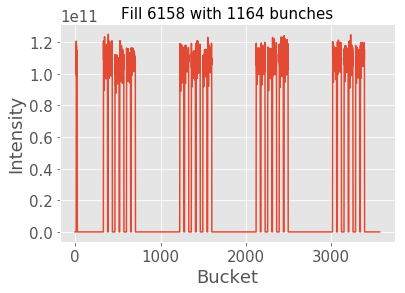

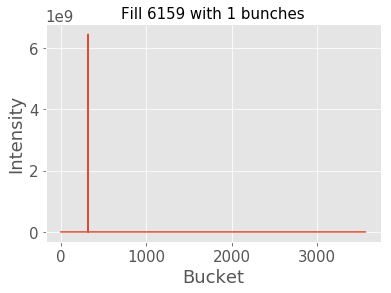

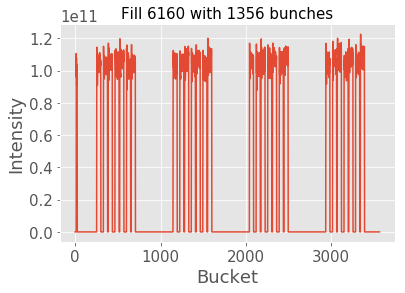

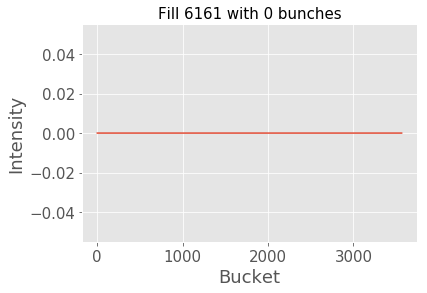

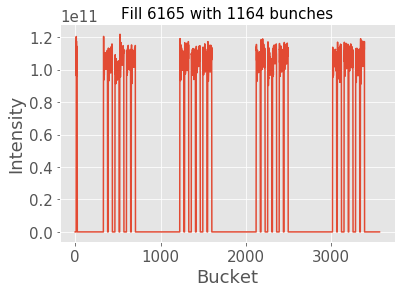

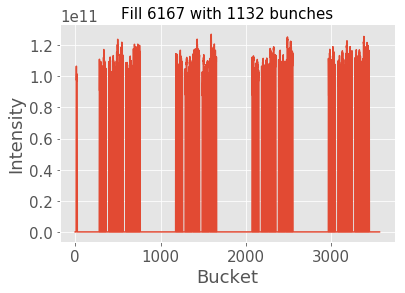

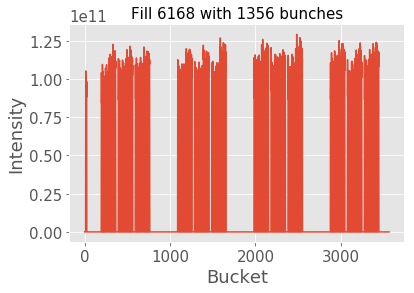

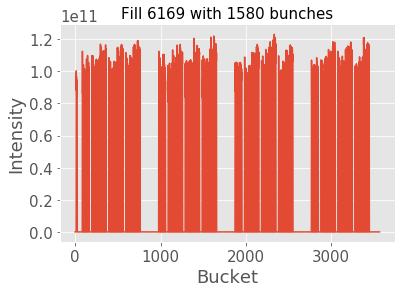

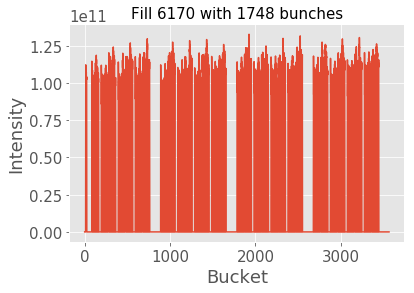

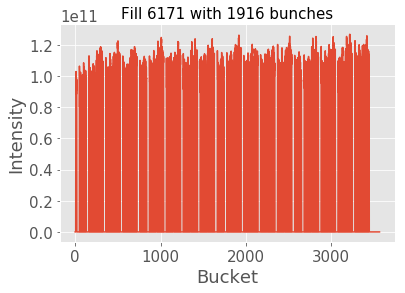

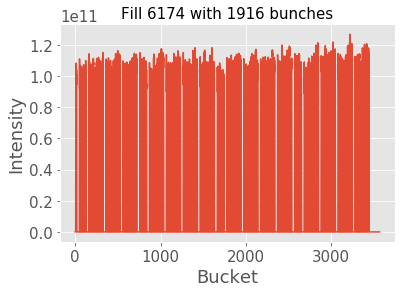

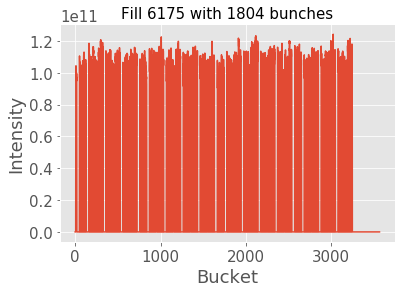

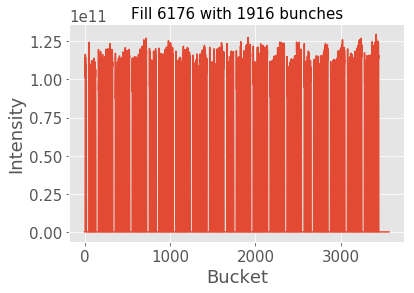

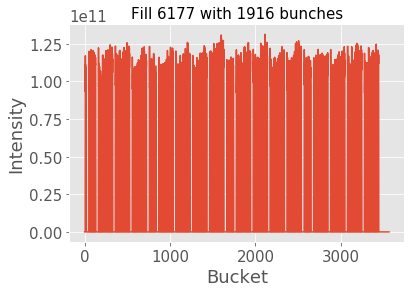

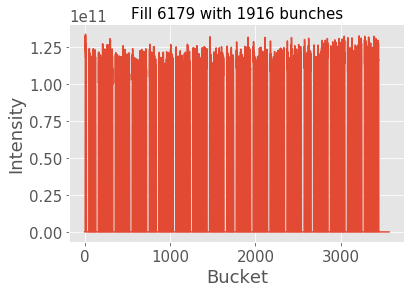

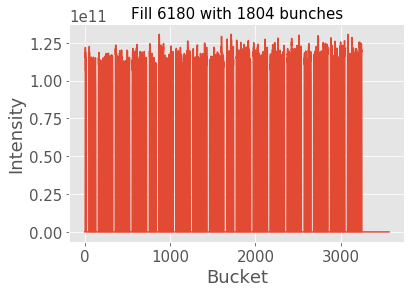

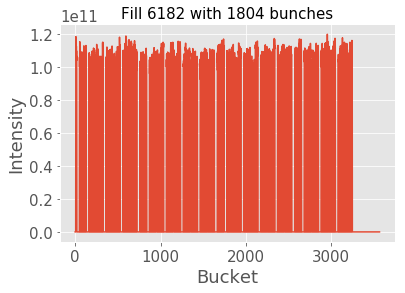

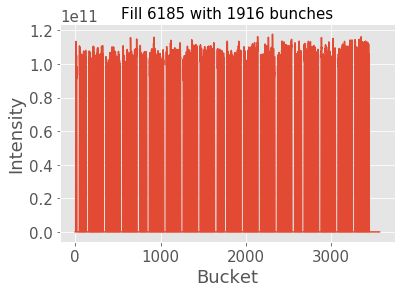

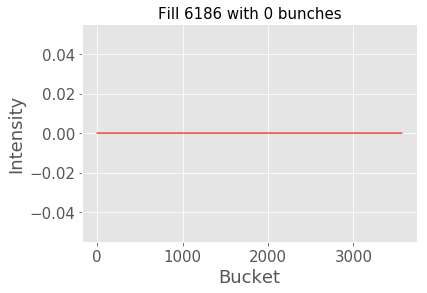

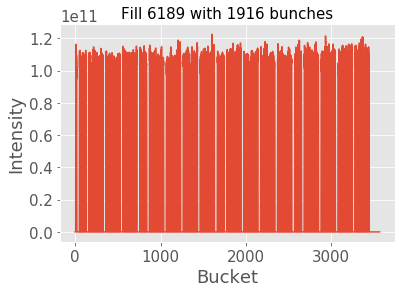

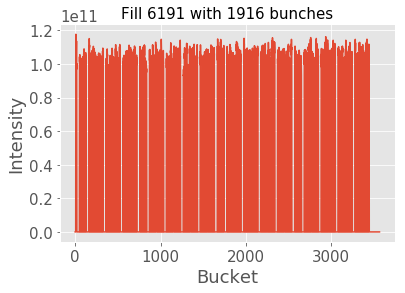

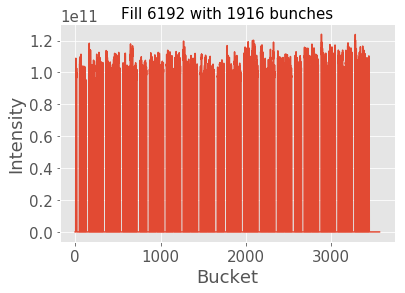

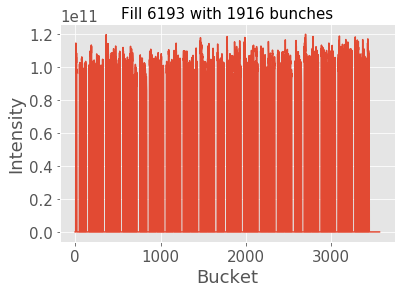

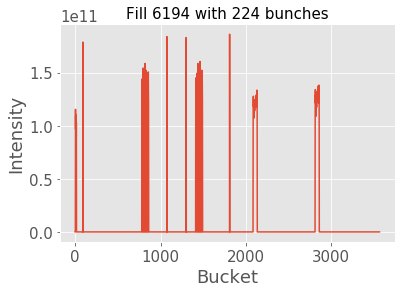

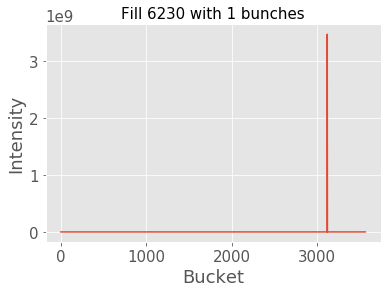

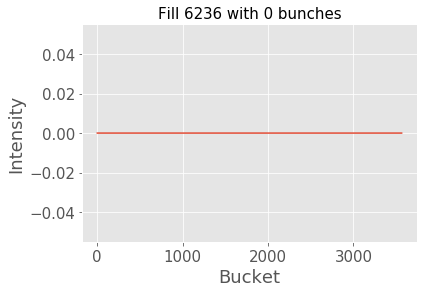

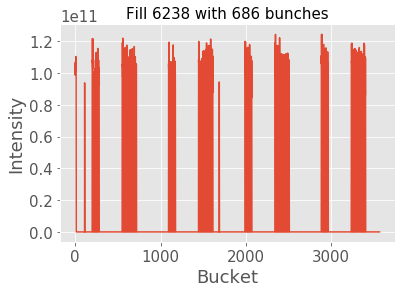

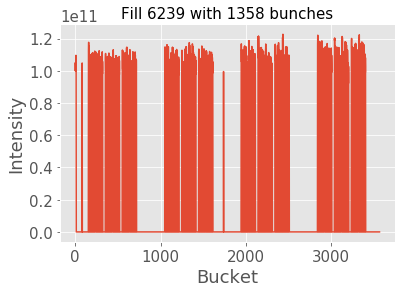

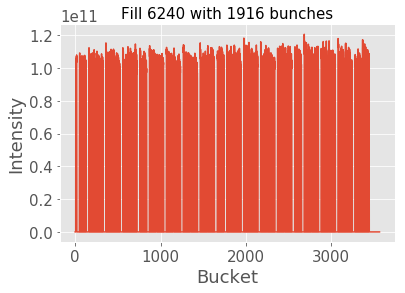

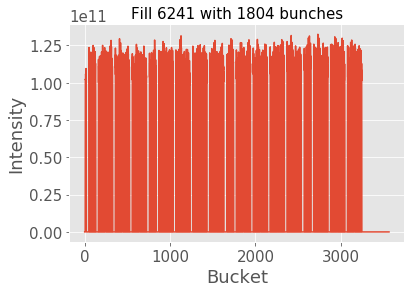

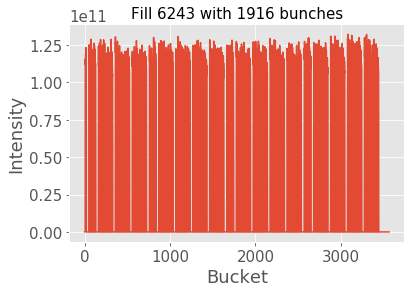

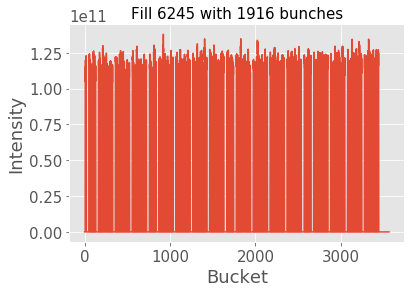

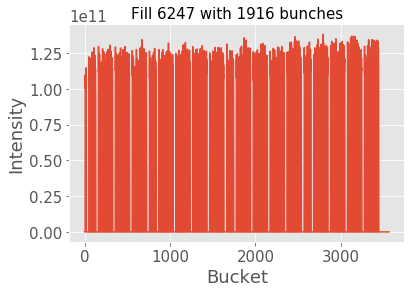

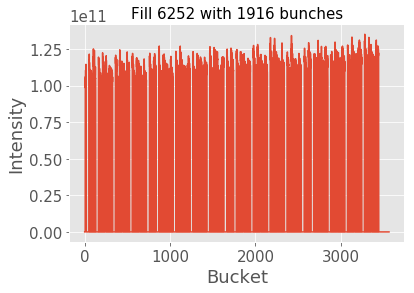

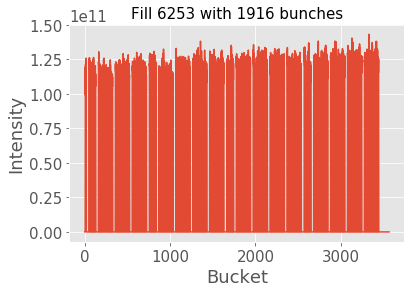

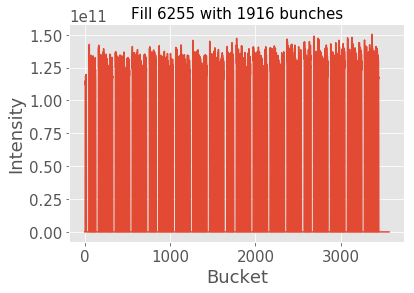

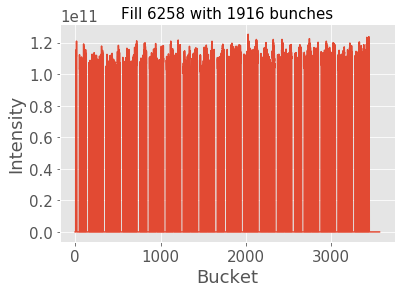

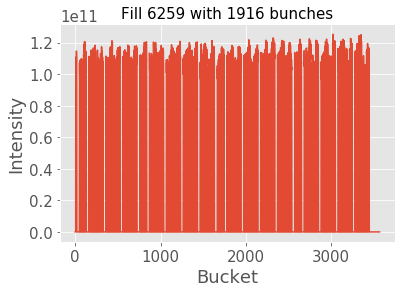

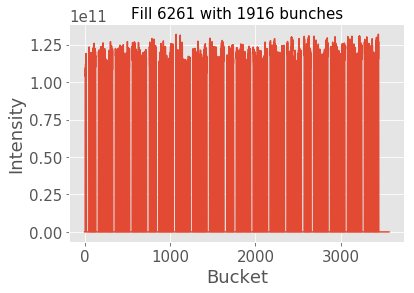

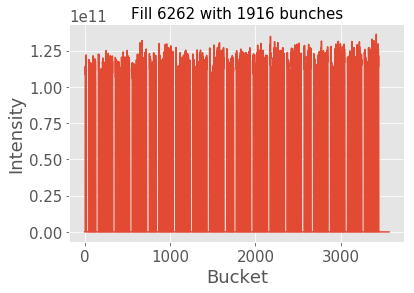

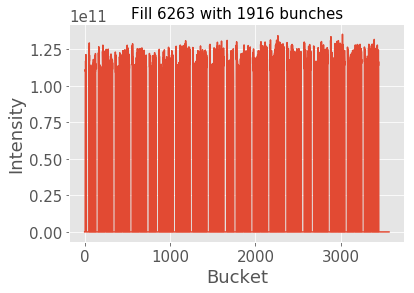

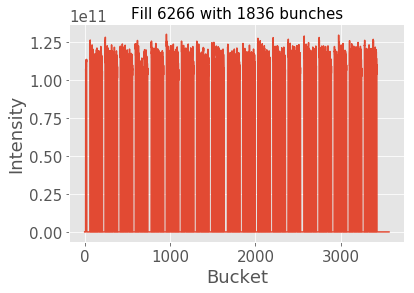

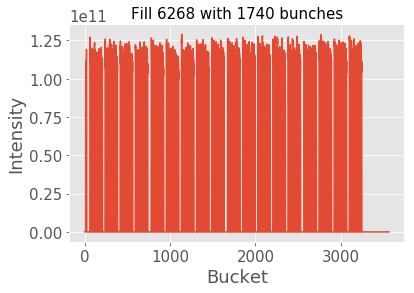

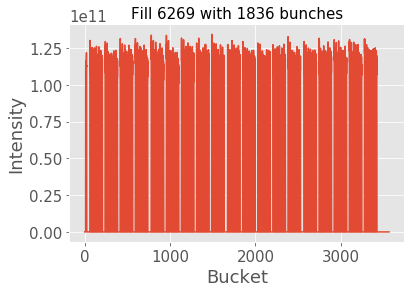

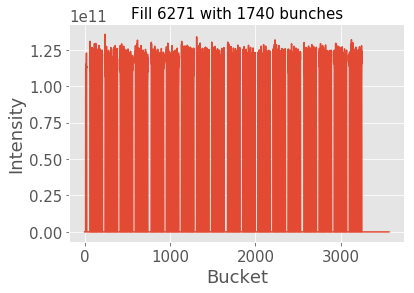

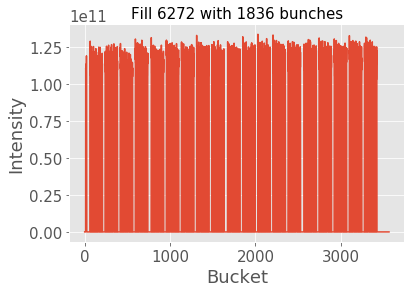

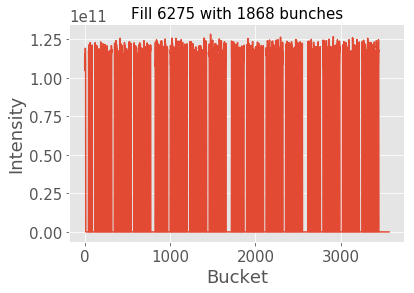

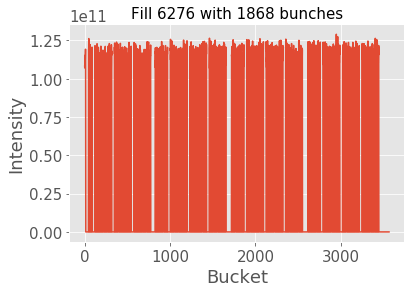

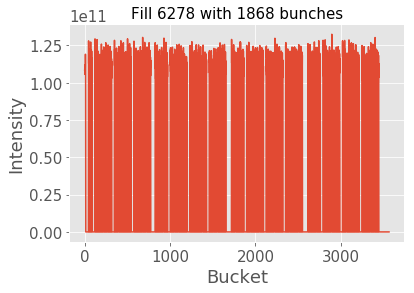

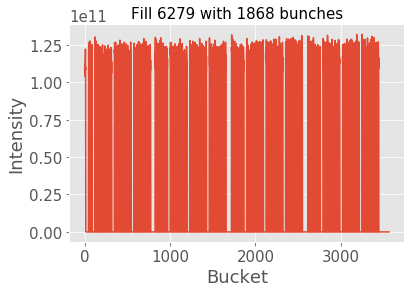

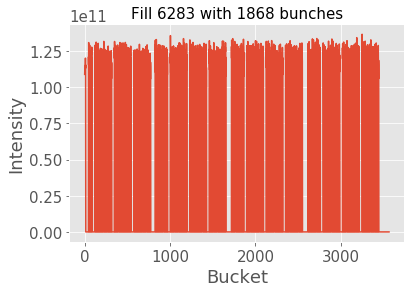

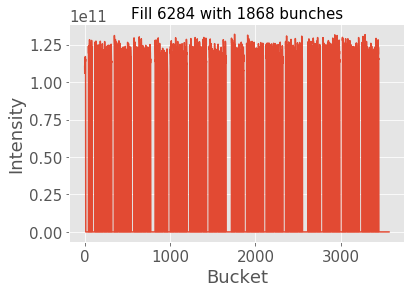

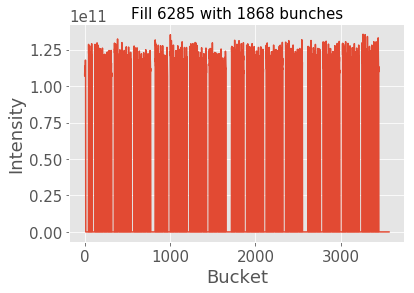

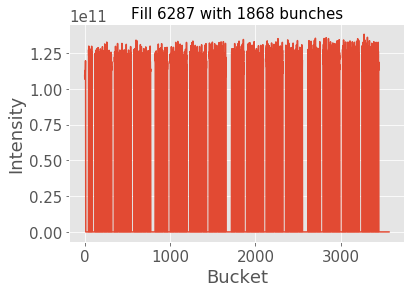

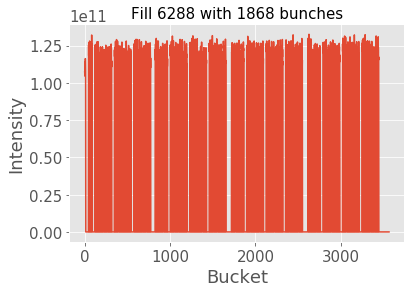

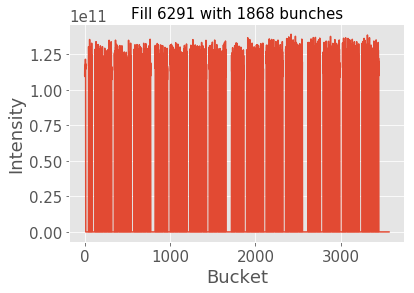

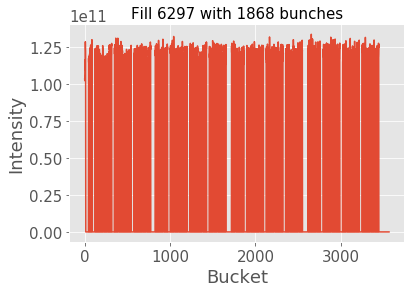

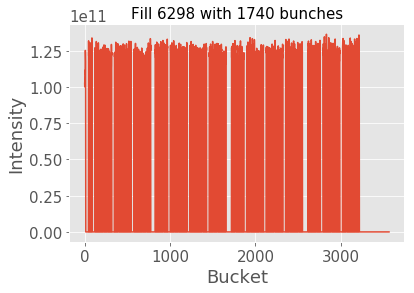

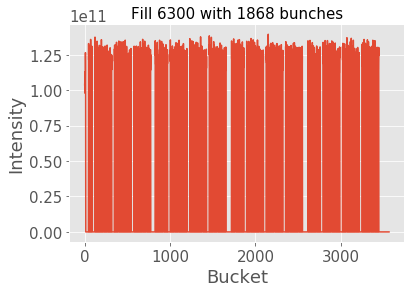

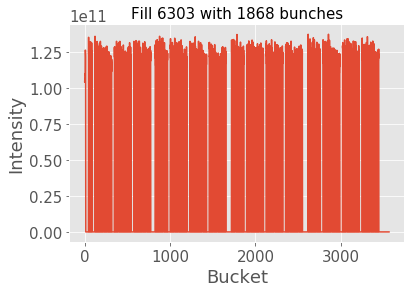

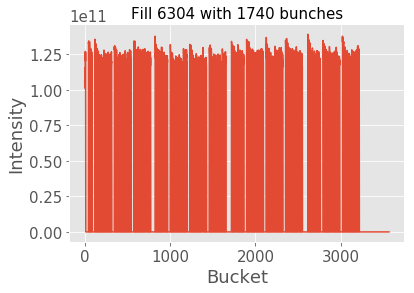

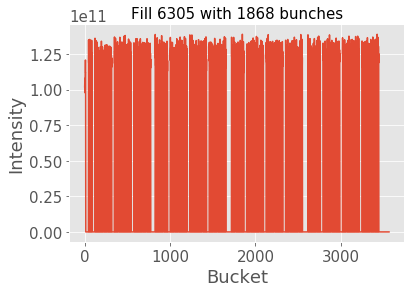

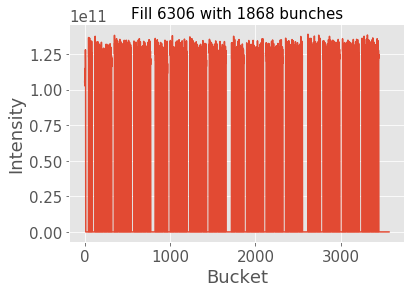

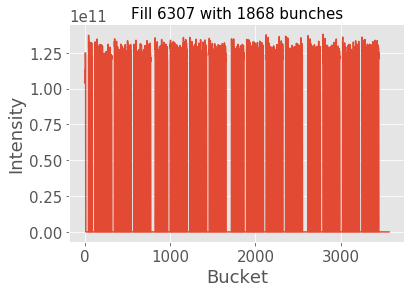

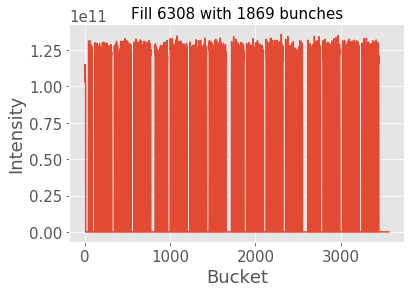

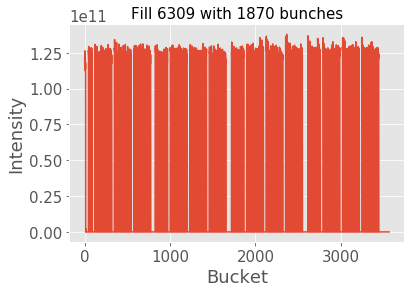

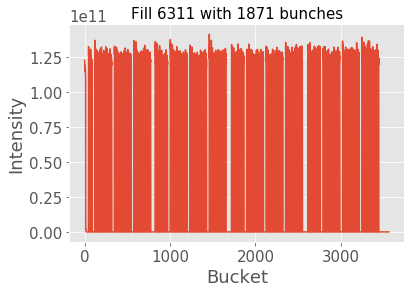

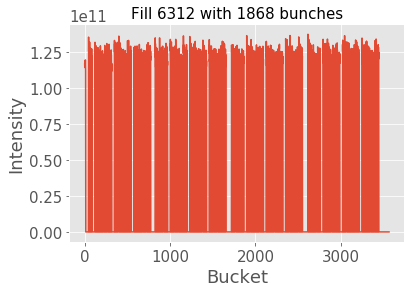

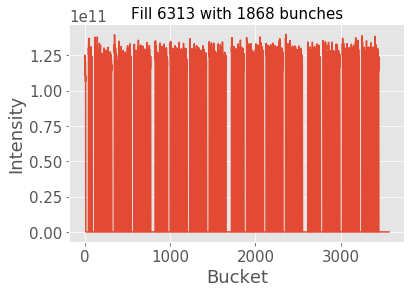

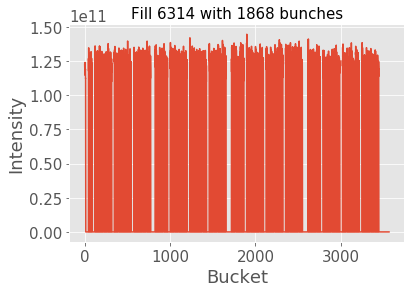

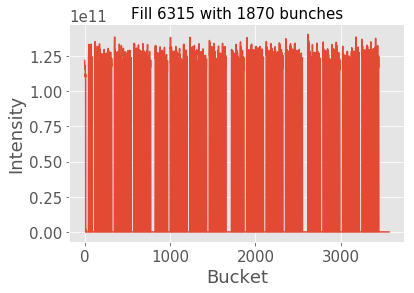

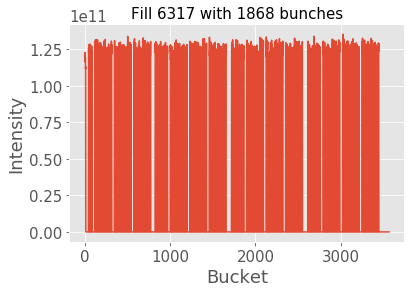

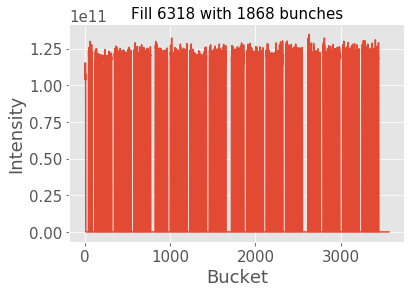

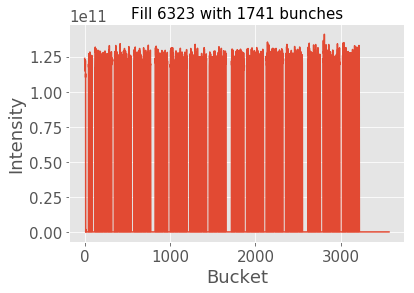

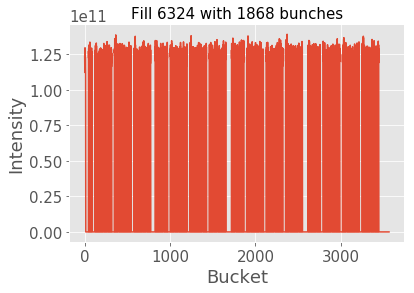

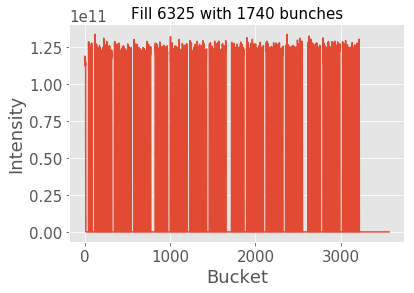

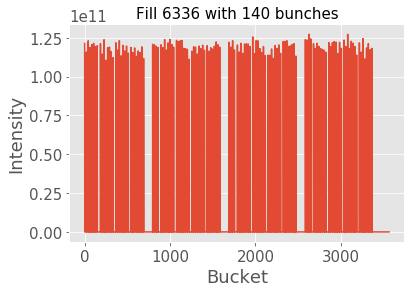

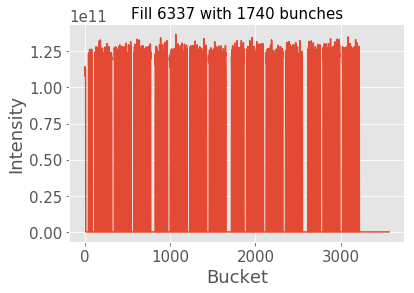

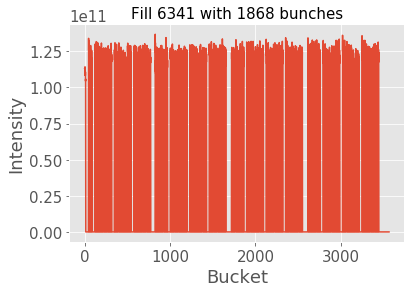

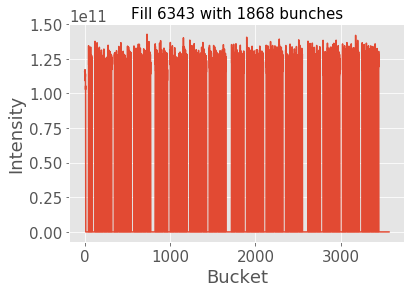

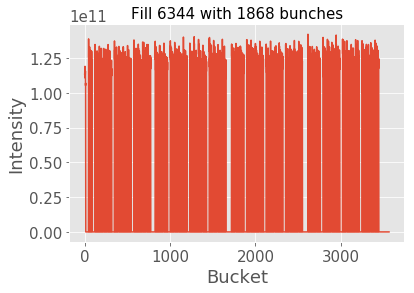

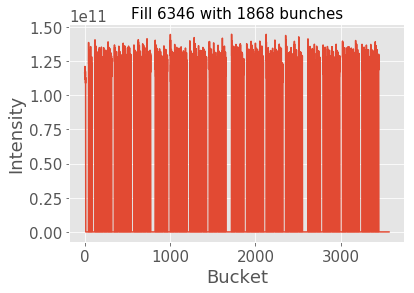

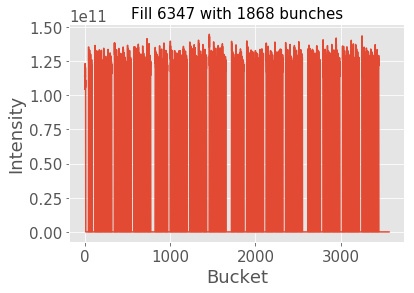

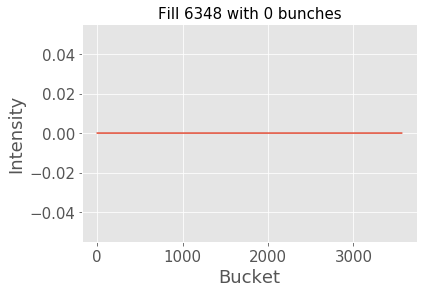

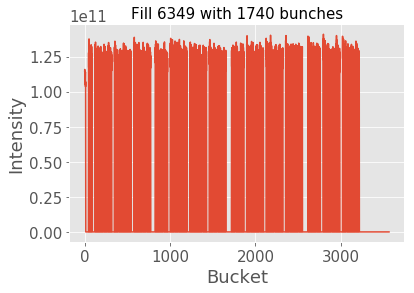

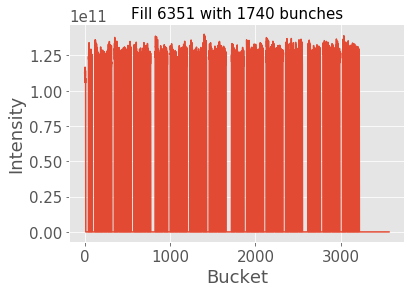

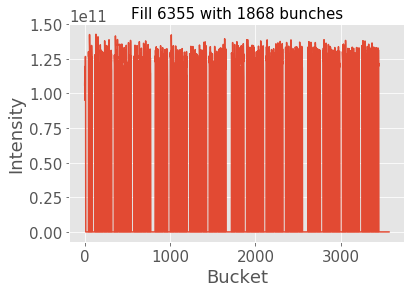

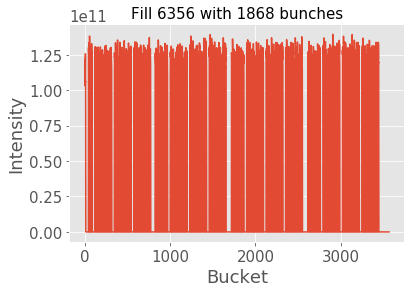

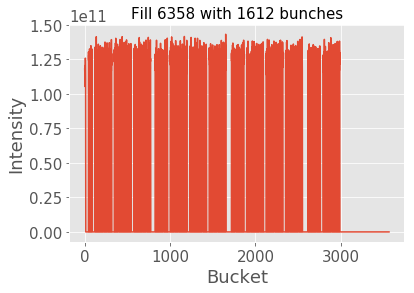

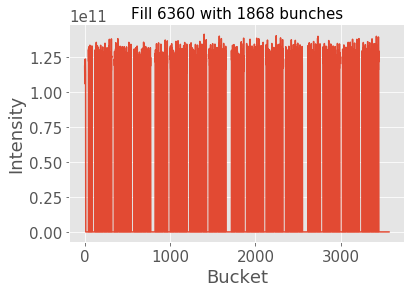

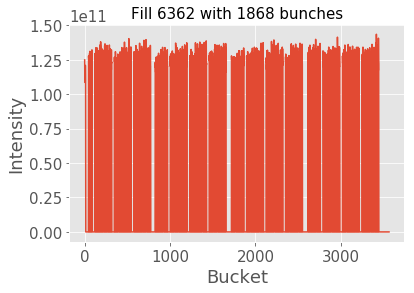

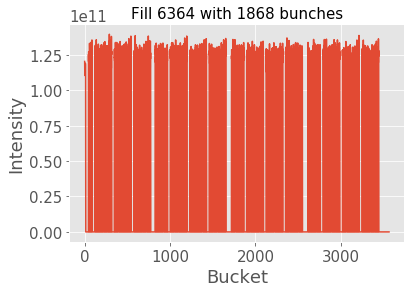

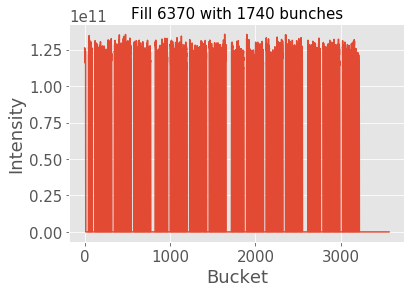

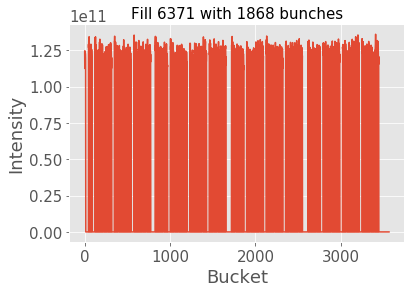

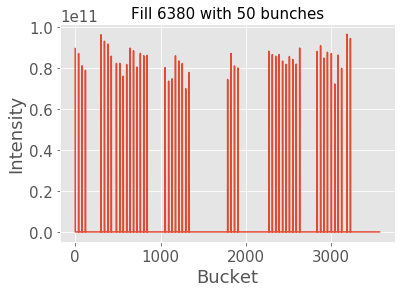

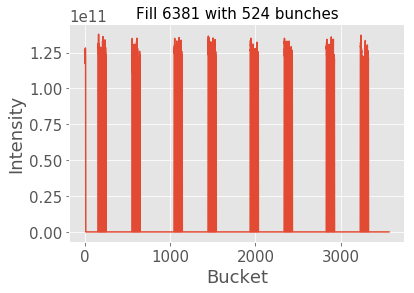

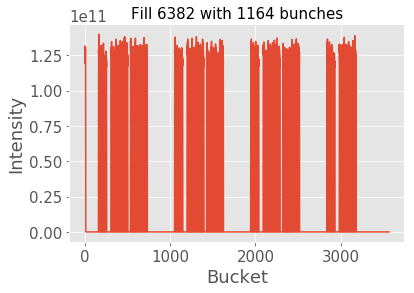

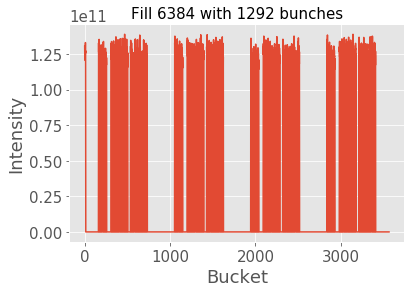

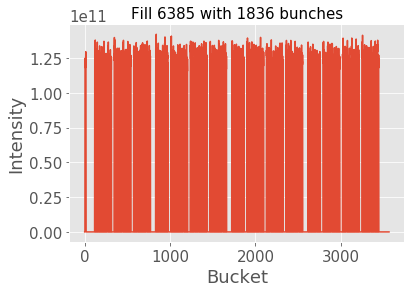

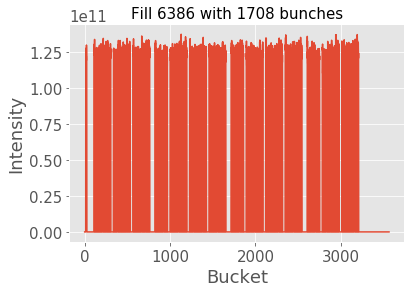

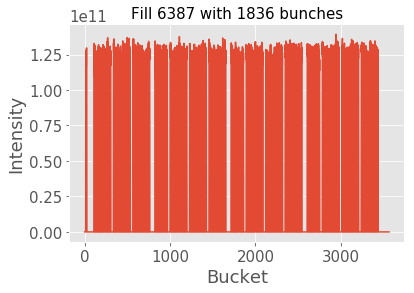

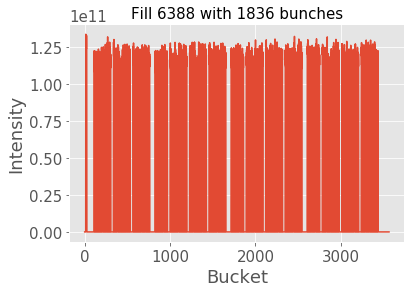

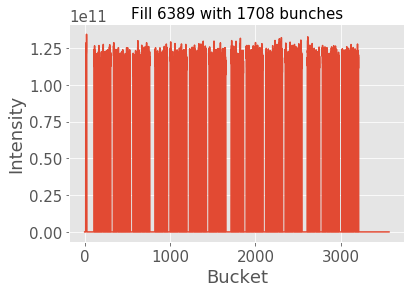

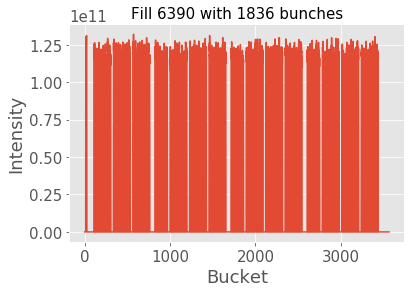

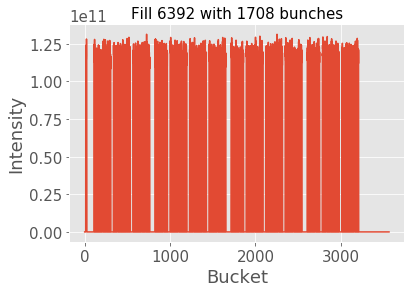

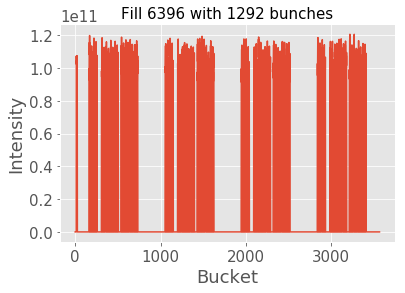

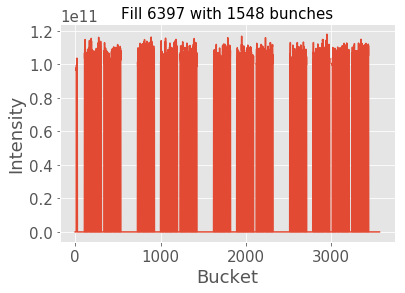

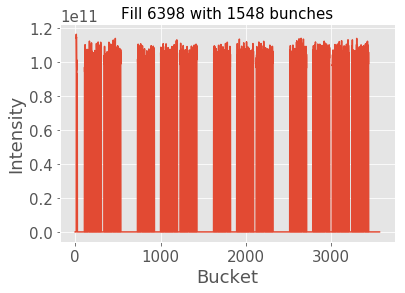

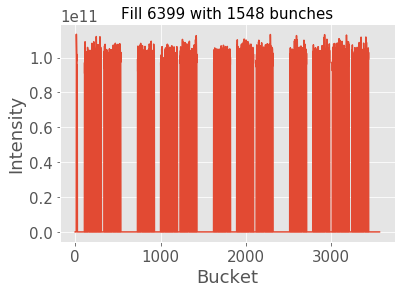

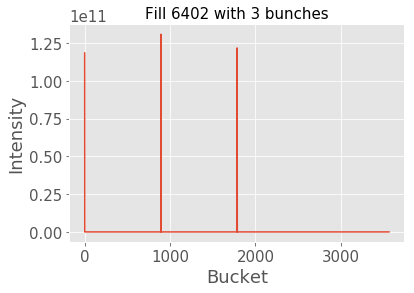

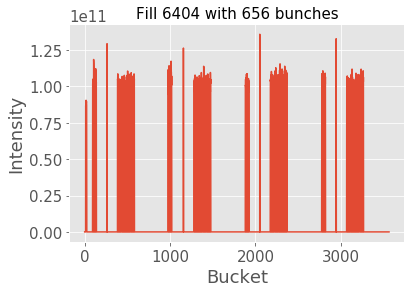

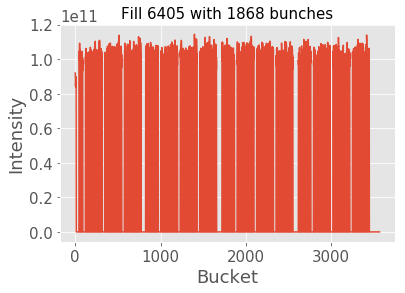

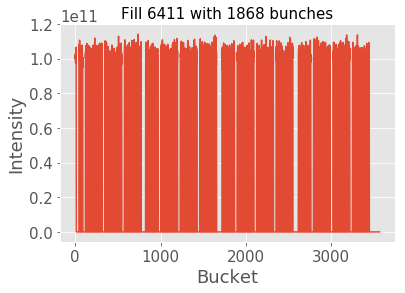

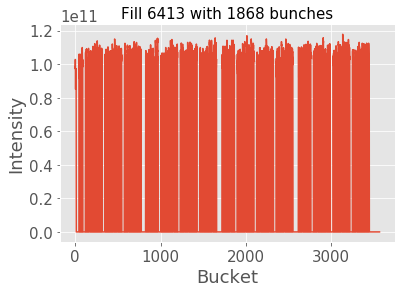

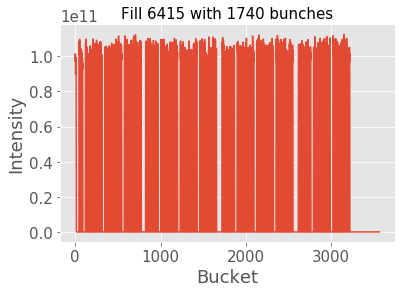

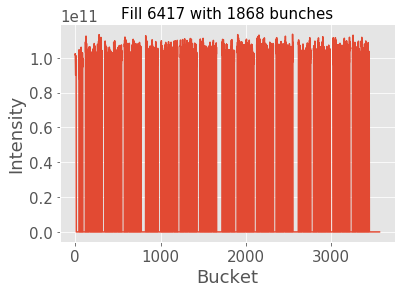

In [131]:
for fill in fills: 
    try:

#         fill            = 5719
        start, end      = get_injection_phases(fill)
        data            = db.get(["LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY"],start,end)

        bb = data['LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY'][1][-1]
        plt.plot(np.arange(1,len(bb)+1),bb)
        plt.title("Fill {0} with {1} bunches".format(fill, len(bb[bb>0])),fontsize=15)
        plt.xlabel("Bucket")
        plt.ylabel("Intensity")
        plt.show()
    except:
        continue

# Check one of the fills

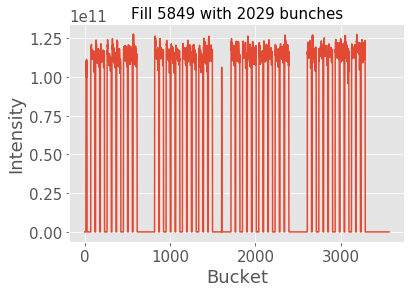

In [113]:
fill = 5849
start, end      = get_injection_phases(fill)
data            = db.get(["LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY"],start,end)

bb = data['LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY'][1][-1]
plt.plot(np.arange(1,len(bb)+1),bb)
plt.title("Fill {0} with {1} bunches".format(fill, len(bb[bb>0])),fontsize=15)
plt.xlabel("Bucket")
plt.ylabel("Intensity")
plt.show()

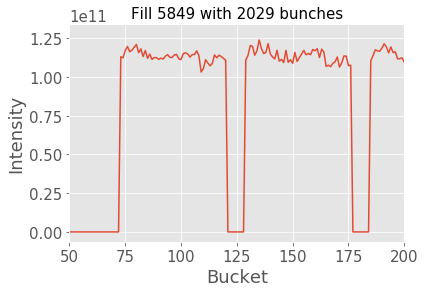

In [114]:
fill = 5849
start, end      = get_injection_phases(fill)
data            = db.get(["LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY"],start,end)

bb = data['LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY'][1][-1]
plt.plot(np.arange(1,len(bb)+1),bb)
plt.title("Fill {0} with {1} bunches".format(fill, len(bb[bb>0])),fontsize=15)
plt.xlabel("Bucket")
plt.xlim(50,200)
plt.ylabel("Intensity")
plt.show()

identify bunch trains

In [184]:


def get_bucket_intensity(bctfr_b1, timestamp_index):
    bb = bctfr_b1[1][timestamp_index]
    tt = bctfr_b1[0][timestamp_index]
    return tt,bb

array([ 16,  73, 129, 185])

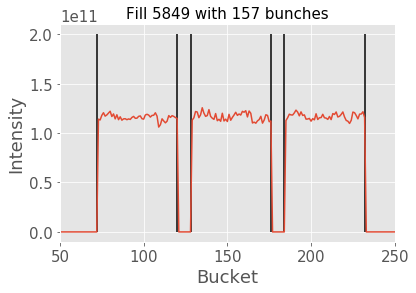

In [194]:
fill = 5849
start, end      = get_injection_phases(fill)
data            = db.get(["LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY"],start,end)

bb = data['LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY'][1][55]
plt.plot(np.arange(1,len(bb)+1),bb)
plt.title("Fill {0} with {1} bunches".format(fill, len(bb[bb>0])),fontsize=15)
plt.xlabel("Bucket")
plt.xlim(50,250)
plt.ylabel("Intensity")
for bucket in np.arange(1,len(bb)+1)[:-1][np.diff(bb)>1e11]:
    plt.vlines(bucket,0,2e11)
for bucket in np.arange(1,len(bb)+1)[:-1][np.diff(bb)<-1e11]:
    plt.vlines(bucket,0,2e11)

plt.show()


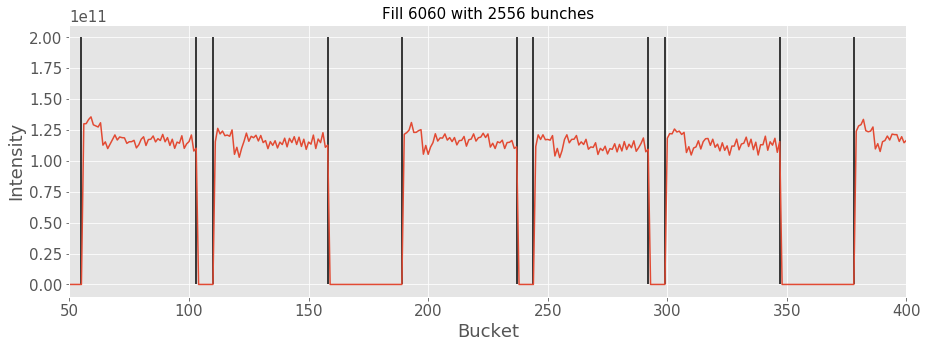

In [410]:

fill = 6060
start, end      = get_injection_phases(fill)
data            = db.get(["LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY"],start,end)
fig = plt.figure(figsize=[15,5])

bb = data['LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY'][1][30]
plt.plot(np.arange(1,len(bb)+1),bb)
plt.title("Fill {0} with {1} bunches".format(fill, len(bb[bb>0])),fontsize=15)
plt.xlabel("Bucket")
plt.xlim(50,400)
plt.ylabel("Intensity")
for bucket in np.arange(1,len(bb)+1)[:-1][np.diff(bb)>1e11]:
    plt.vlines(bucket,0,2e11)
for bucket in np.arange(1,len(bb)+1)[:-1][np.diff(bb)<-1e11]:
    plt.vlines(bucket,0,2e11)

plt.show()


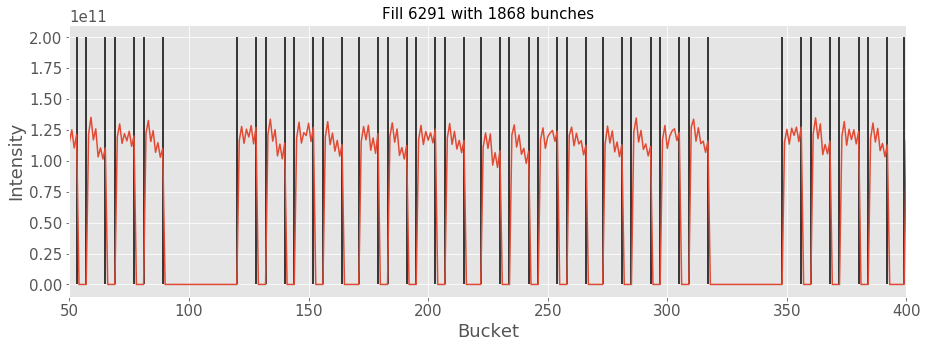

In [408]:

fill = 6291
start, end      = get_injection_phases(fill)
data            = db.get(["LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY"],start,end)
fig = plt.figure(figsize=[15,5])

bb = data['LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY'][1][36]
plt.plot(np.arange(1,len(bb)+1),bb)
plt.title("Fill {0} with {1} bunches".format(fill, len(bb[bb>0])),fontsize=15)
plt.xlabel("Bucket")
plt.xlim(50,400)
plt.ylabel("Intensity")
for bucket in np.arange(1,len(bb)+1)[:-1][np.diff(bb)>1e11]:
    plt.vlines(bucket,0,2e11)
for bucket in np.arange(1,len(bb)+1)[:-1][np.diff(bb)<-1e11]:
    plt.vlines(bucket,0,2e11)

plt.show()


In [190]:
def get_data(beam, fill):
    '''Get the data of the BCTFR for the selected beam and fill. 
    Returns two arrays:
        timestamps, bctf_data'''
    if beam==1:
        bctfr_string = "LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY"
    start, end      = get_injection_phases(fill)
    data            = db.get([bctfr_string],start,end)
    bctf            = data[bctfr_string]
#     print("found fill {0} with length {1}".format(fill,len(bctf[0])))
    return bctf

def get_initial_bunch_ranges(bctf, index):
    '''returns lower and upper indices for the buckets populated with bunch trains '''
    timestamp, bb = get_bucket_intensity(bctf, index)
    
    lower = np.arange(1,len(bb)+1)[:-1][np.diff(bb)>1e11]
    upper = np.arange(1,len(bb)+1)[:-1][np.diff(bb)<-1e11]
    return lower,upper

def get_smallest_timestamp_with_n_bunches(bctf, nbunch):
    '''find the smallest timestamp for which we have at least n bunch trains
       this returns the lower limit index for the time to consider'''
    stop_here=False
    for timestamp_id in range(len(bctf[0])):
        lower, upper = get_initial_bunch_ranges(bctf, timestamp_id)
        if stop_here:
            break
        if len(lower)>nbunch:
            stop_here = True
    return timestamp_id

def get_bucket_intensity(bctf, timestamp_index):
    '''Get the intensity for each bucket for a given timestamp index'''
    bb = bctf[1][timestamp_index]
    tt = bctf[0][timestamp_index]
    return tt,bb

def get_bunch_intensity_bucket_by_bucket(df, lower, upper, timediff, index):
    df_bunch1 = df.iloc[lower[index]:upper[index]]
    df_bunch1 = df_bunch1.assign(ii0=df_bunch1['end']/df_bunch1['start'])
    df_bunch1 = df_bunch1.assign(logii0=np.log(df_bunch1['ii0']))
    df_bunch1 = df_bunch1.assign(tau=(-1)*timediff/df_bunch1['logii0'])
    df_bunch1 = df_bunch1.reset_index(drop=True)
    return df_bunch1

In [191]:
BCTF = get_data(1,5849)

In [134]:
get_initial_bunch_ranges(BCTF,-1)

(array([  72,  128,  184,  263,  319,  375,  454,  510,  566,  819,  875,
         954, 1010, 1066, 1145, 1201, 1257, 1336, 1392, 1448, 1604, 1713,
        1769, 1848, 1904, 1960, 2039, 2095, 2151, 2230, 2286, 2342, 2607,
        2663, 2742, 2798, 2854, 2933, 2989, 3045, 3124, 3180, 3236]),
 array([  27,  120,  176,  232,  311,  367,  423,  502,  558,  614,  867,
         923, 1002, 1058, 1114, 1193, 1249, 1305, 1384, 1440, 1496, 1605,
        1761, 1817, 1896, 1952, 2008, 2087, 2143, 2199, 2278, 2334, 2390,
        2655, 2711, 2790, 2846, 2902, 2981, 3037, 3093, 3172, 3228, 3284]))

58

In [145]:
lower_bunch_indices, upper_bunch_indices = get_initial_bunch_ranges(BCTF,indxmin)

In [288]:
def get_bucket_lifetimes(beam, fill, nbunchtrains=20, minbunchlength=10):
    
    BCTF = get_data(beam, fill)
    indxmin = get_smallest_timestamp_with_n_bunches(BCTF,nbunchtrains)

    timestamp_start,     intensity_start     = get_bucket_intensity(BCTF, indxmin)
    timestamp_end,       intensity_end       = get_bucket_intensity(BCTF, len(BCTF[0])-1)
    lower_bunch_indices, upper_bunch_indices = get_initial_bunch_ranges(BCTF,indxmin)
    
#     minbunchlength = 10
    
    indices = (upper_bunch_indices - lower_bunch_indices) > minbunchlength
    lower_bunch_indices, upper_bunch_indices = lower_bunch_indices[indices], upper_bunch_indices[indices]

    if len(lower_bunch_indices) != len(upper_bunch_indices):
        return None
    
    timediff = timestamp_end - timestamp_start

    # convert to dataframe
    df = pd.DataFrame([])
    df = df.assign(end=intensity_end)
    df = df.assign(start=intensity_start)

    # calculate the lifetime for the different buckets

    df_new = pd.DataFrame(columns=[u'index', u'end', u'start', u'ii0', u'logii0', u'tau'])

    for index in range(len(lower_bunch_indices)):

        df_bunchn = df.iloc[lower_bunch_indices[index]:upper_bunch_indices[index]]
        df_bunchn = df_bunchn.assign(ii0=df_bunchn['end']/df_bunchn['start'])
        df_bunchn = df_bunchn.assign(logii0=np.log(df_bunchn['ii0']))
        df_bunchn = df_bunchn.assign(tau=(-1)*timediff/df_bunchn['logii0'])
        df_bunchn = df_bunchn.reset_index(drop=True)
        df_bunchn = df_bunchn.reset_index()

        df_new = df_new.append(df_bunchn)
        
    return df_new

In [351]:
df = pd.read_csv('/home/phermes/Desktop/exportedCSV-1.csv')
fills = df['Fill Number']

In [352]:
df = pd.DataFrame(columns=[u'index', u'end', u'start', u'ii0', u'logii0', u'tau'])
for fill in fills[1:124]:
    try:
        df = df.append(get_bucket_lifetimes(1,fill,minbunchlength=1))
    except:
#         print('Error in processing fill {0}'.format(fill))
        pass

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 2
  del sys.path[0]


In [353]:
output = []
for i in np.unique(df['index']):
    tmean = df[df['index']==i]['tau'].mean()
    tmin  = np.percentile(df[df['index']==i]['tau'].dropna(), 25)
    tmax  = np.percentile(df[df['index']==i]['tau'].dropna(), 75)

    tsig  = df[df['index']==i]['tau'].std()
    output.append([i,tmean , tmin, tmax, tsig ])
output = pd.DataFrame(output,columns=['index','tau','tmin','tmax','tauerr'])

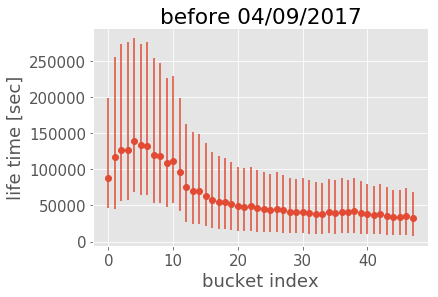

In [354]:
plt.errorbar(output['index'],output['tau'],yerr=[output['tmin'], output['tmax']],fmt='o')
plt.xlabel('bucket index')
plt.ylabel('life time [sec]')
plt.title('before 04/09/2017')
plt.show()

In [342]:
fills = [6171, 6174, 6175, 6176, 6177, 6179, 6180, 6182, 6185, 6189, 6191,
       6192, 6193,6240, 6241, 6243, 6245, 6247, 6252, 6253, 6255, 6258, 6289, 6261,
       6262, 6263, 6266, 6268, 6269, 6271, 6272, 6275, 6276, 6278, 6279,
       6283, 6284, 6285, 6287, 6288, 6291, 6297, 6298,6300, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6311, 6312, 6313,
       6314, 6315, 6317, 6318, 6323, 6324, 6325, 6336, 6337, 6341, 6343,
       6344, 6346, 6347, 6349, 6351, 6355, 6356, 6358, 6360, 6362, 6364,
       6370, 6371, 6385, 6386, 6387, 6388, 6389, 6390, 6392,6405, 6411, 6413, 6415, 6417]

In [343]:
df = pd.DataFrame(columns=[u'index', u'end', u'start', u'ii0', u'logii0', u'tau'])
for fill in fills:
    try:
        df = df.append(get_bucket_lifetimes(1,fill,minbunchlength=1))
    except:
#         print('Error in processing fill {0}'.format(fill))
        pass

In [344]:
output = []
for i in np.unique(df['index']):
    tmean = df[df['index']==i]['tau'].mean()
    tmin  = np.percentile(df[df['index']==i]['tau'].dropna(), 25)
    tmax  = np.percentile(df[df['index']==i]['tau'].dropna(), 75)

    tsig  = df[df['index']==i]['tau'].std()
    output.append([i,tmean , tmin, tmax, tsig ])
output = pd.DataFrame(output,columns=['index','tau','tmin','tmax','tauerr'])

In [394]:
1

1

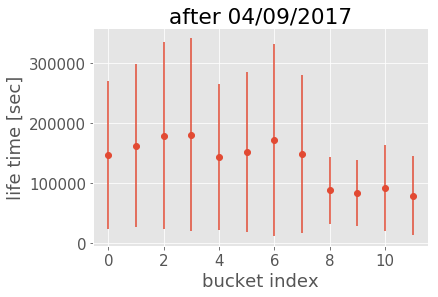

In [345]:
plt.errorbar(output['index'],output['tau'],yerr=output['tauerr'],fmt='o')
plt.xlabel('bucket index')
plt.ylabel('life time [sec]')
plt.title('after 04/09/2017')
# plt.xlim(0,50)
plt.show()